# Gene-level RNA-seq differential expression analysis from aligned data
[Paolo Sonego](paolo.sonego@fmach.it)<sup>*</sup>

<sup>*</sup>Computational Biology Unit,Fondazione Edmund Mach, <br/>
Via Edmund Mach 1, 38010, S. Michele All'Adige, Trento,  Italy

## Introduction
In this practical we will show a standard workflow for the analysis of RNA-seq data. It is not intended as THE Definitive Guide in the analysis of this kind of data; we will cover one of the many existing workflows to analyse RNA-Seq data for a common task, i.e. Differential Expression Analysis.

## Analysis overview
1. Retrieving RNA-seq reads from public repositories
2. Pre-processing (Quality Control, trimming)
3. Alignment and Counting
4. Exploratory Data Analysis
5. Filtering and Normalization
6. Differential Expression Analysis
7. Gene Ontology Enrichment

## Experiment info
As a running example we use a dataset which is available from both the Short Read archive (SRA Study ID: SRP193991 - raw data) and from GEO (GEO Experiment ID: GSE130386 - processed data). The authors investigate the Muscat flavour of three Vitis vinifera genotypes with different aromatic strength by integrating transcript and terpene content metabolite (from which the flavour originates) profiles. 
> A total of 27 fruit samples from three biological replicates were sequenced on Illumina HiSeq2000 at three stages, corresponding to the veraison; berries had intermediate Brix value and were harvest-ripe. 

For more information about this dataset please refer to the original publication:[Transcriptome profiles of three Muscat table grape cultivars to dissect the mechanism of terpene biosynthesis](https://www.nature.com/articles/s41597-019-0101-y). <a href="#ref1">[1]</a>

| Design Type(s) | transcription profiling design • gene expression analysis objective |
|--------------------------|---------------------------------------------------------------------|
| Measurement Type(s) | transcription profiling assay |
| Technology Type(s) | RNA sequencing |
| Factor Type(s) | cultivar • biological replicate • developmental stage |
| Sample Characteristic(s) | Vitis vinifera • berry |

The tools and R packages that we will be using during the practical are listed below and the data used for the analysis can be found at /home/share/RNASeqPractical/.

# Setup

In [50]:
## Setup - loading libraries for the analysis
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(plotly))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(Rsubread))
suppressPackageStartupMessages(library(tximport))
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library(edgeR))
suppressPackageStartupMessages(library(limma))
suppressPackageStartupMessages(library(goseq))
suppressPackageStartupMessages(library(GO.db))

## Setup - setting up paths and options
shared="/home/share/RNASeqPractical"
data="/home/share/RNASeqPractical/data"
tools="/home/share/RNASeqPractical/tools"
references="/home/share/RNASeqPractical/references"
options(repr.plot.width = 15, repr.plot.height = 15) # set plot size

# Retrieving RNA-seq reads from public repositories

## Download raw data (sra/fastq) from NCBI's Sequence Read Archive (SRA)
SRA is one of the primary repositories for next-generation sequencing data. Submissions to SRA can be complex, with multiple samples from a given submission, or multiple sequencing runs associated with a given sample. As a result, a given SRA submission “envelope” can be associated with database records at several levels, each with corresponding identifiers and nomenclature. Valid levels include: the study (prefixed with SRP), the experiment (prefixed with SRX), the sample (prefixed with SRS), and the run (prefixed with SRR). Mapping identifiers between the different parts of an SRA submission is important when you need to access meta-data from different parts of a submission or you need to aggregate data across different levels of a submission (e.g. sequencing runs from the same biological sample)<a href="#ref2">[2]</a>

**DO NOT RUN!!!**
```{r}
suppressPackageStartupMessages(library(SRAdb))
suppressPackageStartupMessages(library(DBI))
if(!file.exists('SRAmetadb.sqlite')) sra_dbname <<- getSRAdbFile()
sra_dbname <- 'SRAmetadb.sqlite'        
con <- dbConnect(dbDriver("SQLite"), sra_dbname)
listSRAfile('SRP193991', con)
getSRAfile('SRP193991', con, fileType = 'fastq', srcType = 'ftp', makeDirectory = TRUE) 
```
or

**DO NOT RUN!!!**
```sh
pysradb download --srp SRP193991
```

# Quality Control

### Activity
- Use FastQC  <a href="#ref3">[3]</a> to generate Quality Control reports for the raw data (fastq files).
- Check the fastqc report on your browser (notebook session)

#### Hint

- Open a terminal and browse the RNASeqPractical directory (`/home/share/RNASeqPractical/data`) looking for the fastq raw data
- From the command line take advantage of the below template to select few samples to check.

```sh
cd $HOME/day_2_rnaseq/
tools="/home/share/RNASeqPractical/tools"
fastq_in="<fastq raw path here>"
mkdir -p $HOME/day_2_rnaseq/QC/raw
fastqc_out=$HOME/day_2_rnaseq/QC/raw
for f in `basename -s .fastq.gz $fastq_in/*.fastq.gz`;
do
  $tools/FastQC/fastqc $fastq_in/$f.fastq.gz -t 1 --extract -o $fastqc_out
done
```
- Use the below base code to inspect the result on your notebook

```{r}
qc_list <- list.files(path="QC/raw",pattern="*.html", full.names=T)
IRdisplay::display_html(paste0(capture.output(print(paste0("<a href=", qc_list,">",qc_list,"</a>"), type = 'html')), collapse=""))
#IRdisplay::display_html('<iframe src="QC/raw/SRR8979775_fastqc/fastqc_report.html" width=1000, height=1000></iframe> ')
```

# Trimming
Raw data in the fastq format was processed and adaptor and low-quality sequence reads were removed from the data sets using trimmomatic <a href="#ref4">[4]</a>. To run the full samples from this dataset would take several hours.

```sh
cd $HOME/day_2_rnaseq/
tools="/home/share/RNASeqPractical/tools"
fastq_in="/home/share/RNASeqPractical/data/fastq/raw"
mkdir -p $HOME/day_2_rnaseq/fastq/trimmed
fastq_out=$HOME/day_2_rnaseq/fastq/trimmed
for f in `basename -s .fastq.gz $fastq_in/*.fastq.gz`;
do
  java -Xmx2096m -jar $tools/Trimmomatic-0.39/trimmomatic-0.39.jar SE -phred33 -threads 8 \
  $fastq_in/$f.fastq.gz \
  $fastq_out/${f}_trim.fastq.gz \
  ILLUMINACLIP:/home/share/RNASeqPractical/tools/Trimmomatic-0.39/adapters/TruSeq3-PE-2.fa:2:30:10
done
```

### Activity
- Open a Terminal, run the trimming software, run FastQC on the result and compare the  report for both pre- and post- trimming fastq files.

### hint
**This step requires a lot of time so try it with one sample** and check the FastQC reports for both raw and trimmed data.

# Alignment
## Build the index
The read sequences are stored in (compressed) FASTQ files. These files must be aligned to the Vitis vinifera genome and counted into annotated genes. The first step in performing the alignment is to build an index. In order to build an index you need to have the fasta file (.fa), which can be downloaded from [Vitis vinifera (12x) genome plants ensembl](http://plants.ensembl.org/Vitis_vinifera/Info/Index) or [CRIBI](http://genomes.cribi.unipd.it/DATA) or [INRA](https://urgi.versailles.inra.fr/download/vitis).
This operation can be done from either the command line:
```sh
cd $HOME/day_2_rnaseq/
tools="/home/share/RNASeqPractical/tools"
references="/home/share/RNASeqPractical/references"
mkdir -p cd $HOME/day_2_rnaseq/subread_idx
$tools/subread-2.0.0-Linux-x86_64/bin/subread-buildindex -B -o subread_idx/Vitis_vinifera.12X.dna.toplevel.subread $references/ensemblgenomes_Vitis_vinifera_release-43/fasta/dna/Vitis_vinifera.12X.dna.toplevel.fa
```
or in R using the `Rsubread` package:
```{r}
references="/home/share/RNASeqPractical/references"
dir.create("subread_idx", showWarnings = T)
buildindex(basename="subread_idx/Vitis_vinifera.12X.dna.toplevel.subread",
reference=paste0(references,"/ensemblgenomes_Vitis_vinifera_release-43/fasta/dna/Vitis_vinifera.12X.dna.toplevel.fa"))
```

## Aligning reads to reference genome

Now that we have generated our index, we can align our reads using the align command using the default mapping parameters. To run the full samples from this dataset would take several hours. The BAM files are saved in the working directory.
To see how many parameters you can change try the `args` function:```{r} args(align) ``` or better take a look at the [documentation](http://subread.sourceforge.net/).The alignement can be done from either the command line:

```sh
cd $HOME/day_2_rnaseq/
subread_idx="$HOME/day_2_rnaseq/subread_idx"
tools="/home/share/RNASeqPractical/tools/subread-2.0.0-Linux-x86_64/bin"
fastq="/home/share/RNASeqPractical/data/fastq/raw"
#fastq="/home/share/RNASeqPractical/data/fastq/trimmed"
mkdir -p $HOME/day_2_rnaseq/bam/raw
#mkdir -p $HOME/day_2_rnaseq/bam/trimmed
bam=$HOME/day_2_rnaseq/bam/raw
#$HOME/day_2_rnaseq/bam/trimmed
$tools/subread-align -T 1 -t 0 -i $subread_idx/Vitis_vinifera.12X.dna.toplevel.subread \
  -r $fastq/SRR8979775.fastq.gz -o $bam/SRR8979775.bam
```

or R:

```{r}
subread_idx='subread_idx'
fastq="/home/share/RNASeqPractical/data/fastq/raw"
dir.create('bam/raw', recursive = TRUE)
bam="bam/raw"
files = list.files(fastq, pattern="fastq.gz",full.names=FALSE)
f = 1
align(index=paste0(subread_idx,"/Vitis_vinifera.12X.dna.toplevel.subread"), 
      readfile1=list.files(fastq, pattern="fastq.gz",full.names=TRUE)[f], 
      output_file=paste0(bam, "/", tools::file_path_sans_ext(files[f], compression=T),".bam"), 
      nthreads = 1)
```

### Activity
Perform the alignement for the same sample for both raw and trimmed data and check the stats.

## Counting
Now that we have figured out where each read comes from in the genome, we need to summarise the information across genes or exons. The alignment produces a set of BAM files, where each file contains the read alignments for each library. In the BAM file, there is a chromosomal location for every read that mapped uniquely. The mapped reads can be counted across grape genes by using the featureCounts <a href="#ref6">[6]</a> function from package `RSubread`. The code below uses the exon intervals defined in the NCBI gtf annotation the V1 grape genome. Reads that map to exons of genes are added together to obtain the count for each gene, with some care taken with reads that span exon-exon boundaries. featureCounts takes all the BAM files as input, and outputs an object which includes the count matrix. Each sample is a separate column, each row is a gene.

```{r}
gtf="/home/share/RNASeqPractical/references/ensemblgenomes_Vitis_vinifera_release-43/gtf/Vitis_vinifera.12X.43.chr.gtf"
bam <- "bam/raw"
bamFiles <- list.files(bam,pattern=".*bam$", full.names = TRUE)
fc <- featureCounts(files = bamFiles, 
    nthreads = 1,
    strandSpecific = 0,
    isPairedEnd = FALSE,
    GTF.featureType="gene",
    GTF.attrType="gene_id",
    annot.ext=gtf, 
    isGTFAnnotationFile=TRUE )
```

### Activity

- Take a look at the different slots of the featureCounts object (hint: names(fc))
- Check the alignment stats.
- Save the counts in a text file and write a external representation of the object in a file (see `?save`).

## EDA - Activity
- load the full counts matrix from `/home/share/RNASeqPractical/data/counts/subread_counts`; you can select either the trimmed fastq (`fc_trimmed.rda`) or the raw fastq (`fc_raw.rda`) for the forthcoming downstream analysis.
- From the counts matrix fc:
    - check the library size for all the samples 
    - show a barplot with library size information
    - do a pairwise comparison of samples using scatterplots (or the `smoothScatter()` function)

## EDA - barplot

SRR8979775.bam SRR8979776.bam SRR8979777.bam SRR8979778.bam SRR8979779.bam 
      12256681       11772622       12420406       11955553       24117422 
SRR8979780.bam SRR8979781.bam SRR8979782.bam SRR8979783.bam SRR8979784.bam 
      23121570       12122439       11660822       12287005       11836107 
SRR8979785.bam SRR8979786.bam SRR8979787.bam SRR8979788.bam SRR8979789.bam 
      24736302       23670784       27918568       26460578       25699693 
SRR8979790.bam SRR8979791.bam SRR8979792.bam SRR8979793.bam SRR8979794.bam 
      24482564       23756906       22740322       25105811       24000712 
SRR8979795.bam SRR8979796.bam SRR8979797.bam SRR8979798.bam SRR8979799.bam 
      26460454       25592774       10787898       10350863       10926892 
SRR8979800.bam SRR8979801.bam SRR8979802.bam SRR8979803.bam SRR8979804.bam 
      10519177       10422295        9927237       10567621       10039226 
SRR8979805.bam SRR8979806.bam SRR8979807.bam SRR8979808.bam SRR8979809.bam 
      12293350       11844823       12456408       12033690       24878322 
SRR8979810.bam SRR8979811.bam SRR8979812.bam SRR8979813.bam SRR8979814.bam 
      23623814       12566540       11937043       12746685       12127114 
SRR8979815.bam SRR8979816.bam SRR8979817.bam SRR8979818.bam SRR8979819.bam 
      11749947       11065434       12466842       11705571       19386471 
SRR8979820.bam SRR8979821.bam SRR8979822.bam SRR8979823.bam SRR8979824.bam 
      18421744       12125309       11603792       12290613       11752243 
SRR8979825.bam SRR8979826.bam SRR8979827.bam SRR8979828.bam SRR8979829.bam 
      23894642       21593072       13995503       13480624       14169674 
SRR8979830.bam SRR8979831.bam SRR8979832.bam SRR8979833.bam SRR8979834.bam 
      13640770       20560720       18939511       14148613       13537953 
SRR8979835.bam SRR8979836.bam SRR8979837.bam SRR8979838.bam SRR8979839.bam 
      14313986       13681355       25343726       24092234       13598751 
SRR8979840.bam SRR8979841.bam SRR8979842.bam SRR8979843.bam SRR8979844.bam 
      12992792       13961622       13275769       13439786       12777056 
SRR8979845.bam SRR8979846.bam SRR8979847.bam SRR8979848.bam SRR8979849.bam 
      13590341       12906033       20512933       19073915       13163908 
SRR8979850.bam SRR8979851.bam SRR8979852.bam SRR8979853.bam SRR8979854.bam 
      12594645       13306229       12725324       17975829       16343730

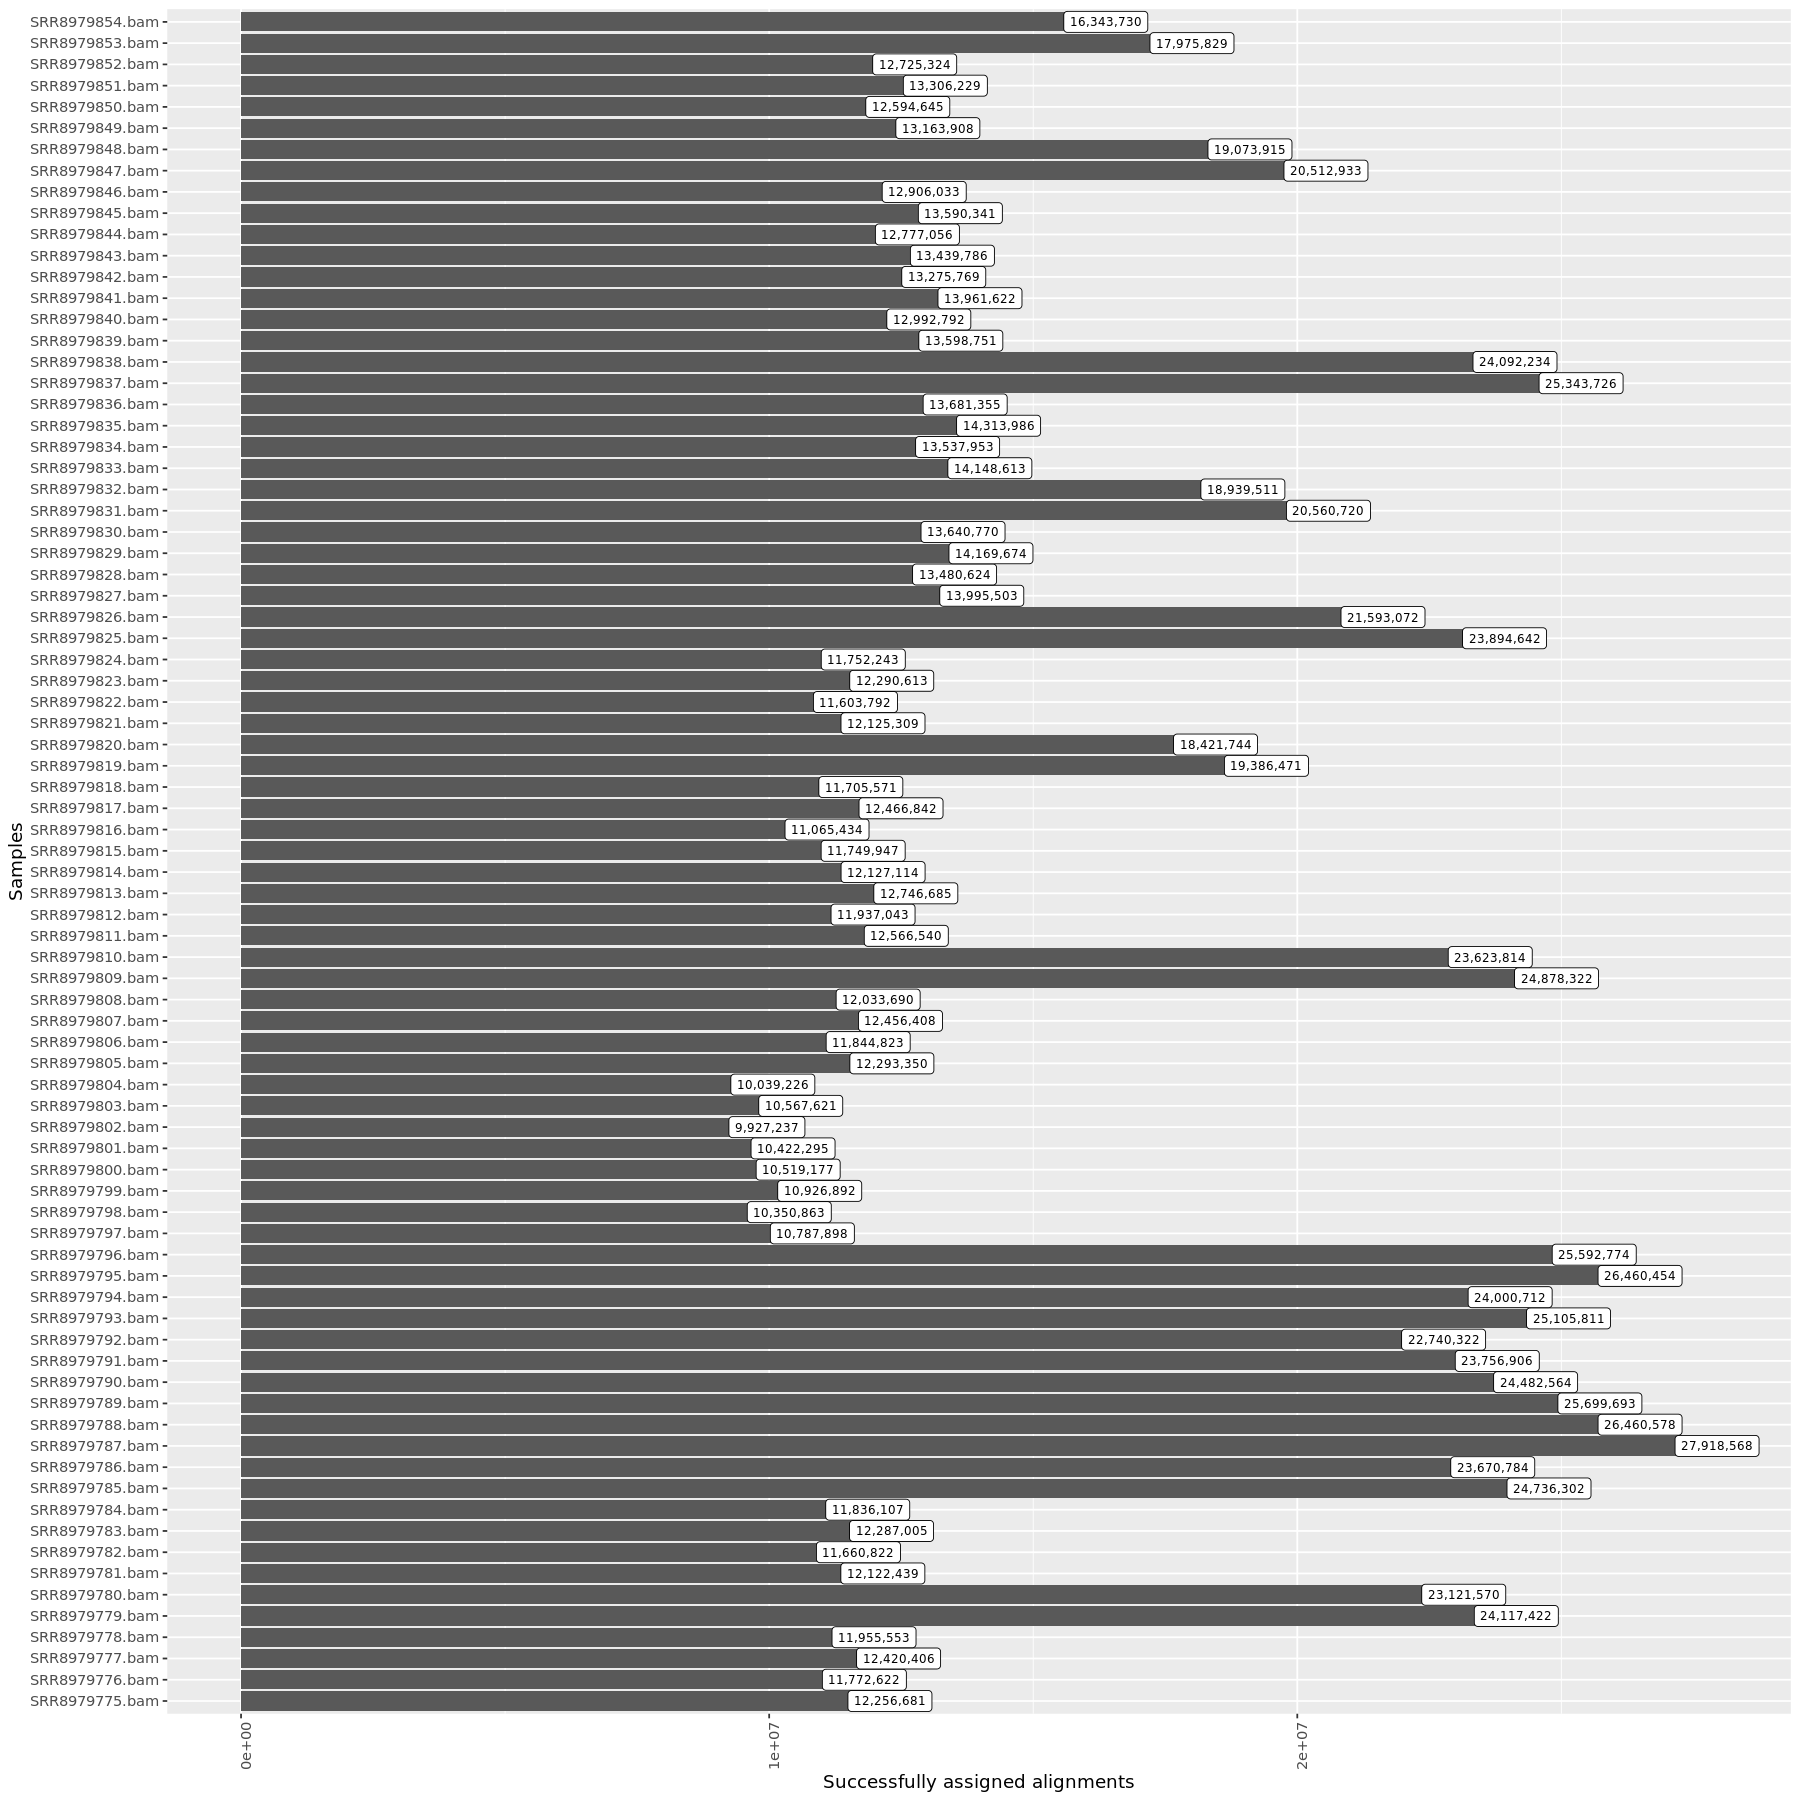

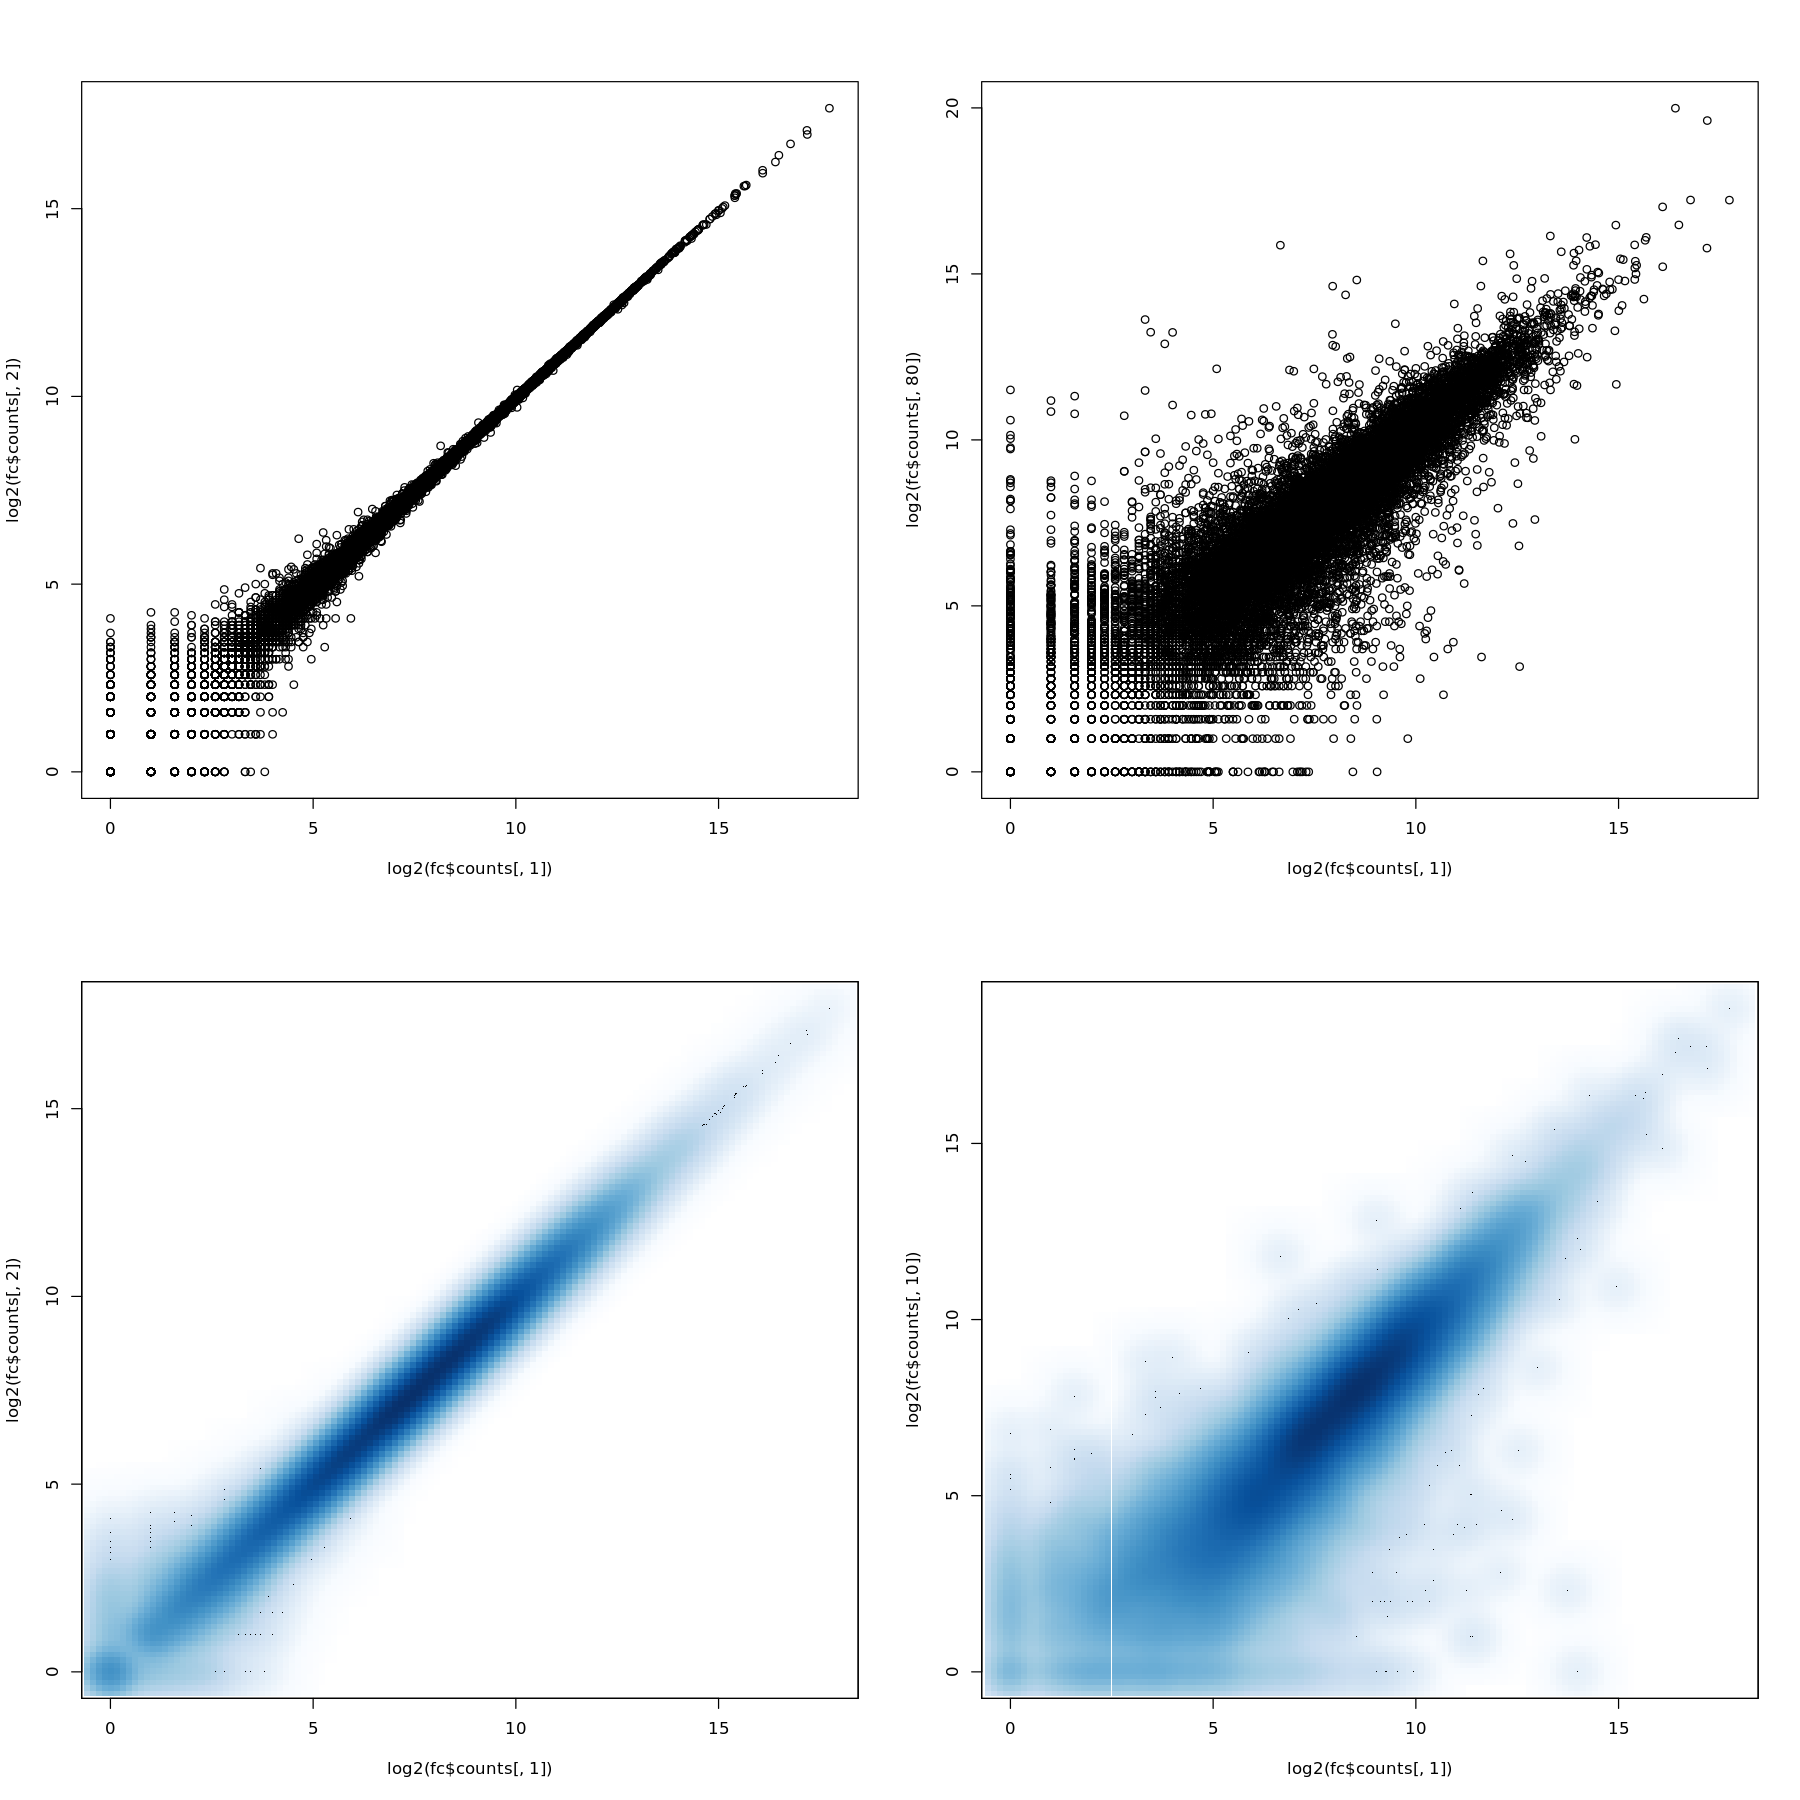

In [2]:
load("/home/share/RNASeqPractical/data/counts/subread_counts/fc_raw.rda")
#load("/home/share/RNASeqPractical/data/counts/subread_counts/fc_trimmed.rda")
fc$counts %>% colSums()
# base R barplot
#barplot(colSums(fc$counts), las=2, border = 0, cex.lab=1, cex.axis=1, font=1,col.axis="black")
## ggplot2 barplot
options(repr.plot.width = 15, repr.plot.height = 15)
fc$counts %>% 
colSums() %>% 
tibble::enframe(name = NULL) %>% 
ggplot(aes(x=colnames(fc$counts),y=value)) + 
geom_col() + 
theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
xlab("Samples") + ylab("Successfully assigned alignments") + coord_flip()  + 
geom_label(aes(label=scales::comma(colSums(fc$counts))), nudge_y = 30000, size=2.5)
## EDA - scatterplots
par(mfrow=c(2,2))
plot(log2(fc$counts[,1]),log2(fc$counts[,2]))
plot(log2(fc$counts[,1]),log2(fc$counts[,80]))
smoothScatter(log2(fc$counts[,1]),log2(fc$counts[,2]))
smoothScatter(log2(fc$counts[,1]),log2(fc$counts[,10]))

In [4]:
head(fc$counts)
head(cpm(fc$counts,log=TRUE, prior.count=3))

SRR8979775.bam SRR8979776.bam SRR8979777.bam SRR8979778.bam
VIT_14s0060g00010    2              4              3              3          
VIT_14s0060g00040   26             26             33             31          
VIT_14s0060g00050   63             68             62             60          
VIT_14s0060g00060 2506           2402           2485           2392          
VIT_14s0060g00070    0              0              0              0          
VIT_14s0060g00080  201            210            204            198          
                  SRR8979779.bam SRR8979780.bam SRR8979781.bam SRR8979782.bam
VIT_14s0060g00010   11              9              2              2          
VIT_14s0060g00040    8              6              0              0          
VIT_14s0060g00050   69             66             37             35          
VIT_14s0060g00060 3049           2987           1804           1775          
VIT_14s0060g00070    0              0              0              0          
VIT_14s0060g00080  340            324            292            270          
                  SRR8979783.bam SRR8979784.bam ⋯ SRR8979845.bam SRR8979846.bam
VIT_14s0060g00010    1              2           ⋯    0              3          
VIT_14s0060g00040    1              1           ⋯   23             22          
VIT_14s0060g00050   45             41           ⋯   28             28          
VIT_14s0060g00060 1757           1723           ⋯ 2280           2215          
VIT_14s0060g00070    0              0           ⋯    0              0          
VIT_14s0060g00080  271            250           ⋯  414            398          
                  SRR8979847.bam SRR8979848.bam SRR8979849.bam SRR8979850.bam
VIT_14s0060g00010   18              9              3              3          
VIT_14s0060g00040   11              7             32             27          
VIT_14s0060g00050  151            134             91             84          
VIT_14s0060g00060 4747           4494           2705           2629          
VIT_14s0060g00070    0              0              0              0          
VIT_14s0060g00080  426            432            198            205          
                  SRR8979851.bam SRR8979852.bam SRR8979853.bam SRR8979854.bam
VIT_14s0060g00010    8              8             15             26          
VIT_14s0060g00040   22             18             25             23          
VIT_14s0060g00050   91             82             70             66          
VIT_14s0060g00060 2777           2696           3822           3628          
VIT_14s0060g00070    0              0              1              0          
VIT_14s0060g00080  267            264            275            248

SRR8979775.bam SRR8979776.bam SRR8979777.bam SRR8979778.bam
VIT_14s0060g00010 -1.514448      -0.9251511     -1.222997      -1.191711     
VIT_14s0060g00040  1.206734       1.2602469      1.507805       1.474976     
VIT_14s0060g00050  2.413298       2.5760300      2.372573       2.380020     
VIT_14s0060g00060  7.676992       7.6739768      7.645736       7.645739     
VIT_14s0060g00070 -2.420016      -2.4200159     -2.420016      -2.420016     
VIT_14s0060g00080  4.051900       4.1719149      4.054105       4.065933     
                  SRR8979779.bam SRR8979780.bam SRR8979781.bam SRR8979782.bam
VIT_14s0060g00010 -0.6372087     -0.7956066     -1.507019      -1.480484     
VIT_14s0060g00040 -0.9474050     -1.1637464     -2.420016      -2.420016     
VIT_14s0060g00050  1.6077944      1.6047026      1.695568       1.672813     
VIT_14s0060g00060  6.9842468      7.0153987      7.219185       7.251775     
VIT_14s0060g00070 -2.4200159     -2.4200159     -2.420016      -2.420016     
VIT_14s0060g00080  3.8363828      3.8277924      4.601364       4.544813     
                  SRR8979783.bam SRR8979784.bam ⋯ SRR8979845.bam SRR8979846.bam
VIT_14s0060g00010 -1.898399      -1.490746      ⋯ -2.4200159     -1.2539334    
VIT_14s0060g00040 -1.898399      -1.881819      ⋯  0.9101431      0.9195175    
VIT_14s0060g00050  1.944581       1.868224      ⋯  1.1680901      1.2365730    
VIT_14s0060g00060  7.161720       7.187434      ⋯  7.3919138      7.4246866    
VIT_14s0060g00070 -2.420016      -2.420016      ⋯ -2.4200159     -2.4200159    
VIT_14s0060g00080  4.475258       4.413368      ⋯  4.9377989      4.9553655    
                  SRR8979847.bam SRR8979848.bam SRR8979849.bam SRR8979850.bam
VIT_14s0060g00010  0.08997123    -0.6023010     -1.269687      -1.234294     
VIT_14s0060g00040 -0.46773101    -0.8524398      1.388323       1.220715     
VIT_14s0060g00050  2.91610608     2.8504300      2.827756       2.777441     
VIT_14s0060g00060  7.85550234     7.8813985      7.684208       7.706850     
VIT_14s0060g00070 -2.42001587    -2.4200159     -2.420016      -2.420016     
VIT_14s0060g00080  4.38916977     4.5132114      3.928652       4.041209     
                  SRR8979851.bam SRR8979852.bam SRR8979853.bam SRR8979854.bam
VIT_14s0060g00010 -0.3435932     -0.2942051      0.03041752     0.8299937    
VIT_14s0060g00040  0.8798739      0.6792940      0.65774062     0.6727612    
VIT_14s0060g00050  2.8126530      2.7291602      2.02891235     2.0789850    
VIT_14s0060g00060  7.7065722      7.7282456      7.73339244     7.7955067    
VIT_14s0060g00070 -2.4200159     -2.4200159     -2.04403653    -2.4200159    
VIT_14s0060g00080  4.3400379      4.3876989      3.95281525     3.9411874

# Design
Retrieve metadata about the esperiment and samples. There are several ways to do this using R (e.g. package `GREP2`), the command line (`pysradb`) or directly from the web. My suggestion for this case is to go to [SRA Run Selector](https://www.ncbi.nlm.nih.gov/Traces/study/) and use either the SRA experiment id `SRP193991` or the Bioproject id `PRJNA539964` for downloading `RunInfo Table`; then you can read the downloaded file into R.
### Question
- Inspect the file
- What metadata tell us about the experiment?

In [5]:
SRP193991_metadata <- read.table("/home/share/RNASeqPractical/data/SraRunTable.txt", header=T, sep=",")

In [51]:
head(SRP193991_metadata)

Run        Assay.Type AvgSpotLen BioProject  BioSample    Center.Name Consent
1 SRR8979775 RNA-Seq    149        PRJNA539964 SAMN11518832 GEO         public 
2 SRR8979776 RNA-Seq    149        PRJNA539964 SAMN11518832 GEO         public 
3 SRR8979777 RNA-Seq    149        PRJNA539964 SAMN11518832 GEO         public 
4 SRR8979778 RNA-Seq    149        PRJNA539964 SAMN11518832 GEO         public 
5 SRR8979779 RNA-Seq    148        PRJNA539964 SAMN11518830 GEO         public 
6 SRR8979780 RNA-Seq    148        PRJNA539964 SAMN11518830 GEO         public 
  Cultivar DATASTORE.filetype DATASTORE.provider ⋯ MBytes Organism      
1 Xiangfei sra                gs,ncbi,s3         ⋯  841   Vitis vinifera
2 Xiangfei sra                gs,ncbi,s3         ⋯ 1013   Vitis vinifera
3 Xiangfei sra                gs,ncbi,s3         ⋯  838   Vitis vinifera
4 Xiangfei sra                gs,ncbi,s3         ⋯ 1035   Vitis vinifera
5 Xiangfei sra                gs,ncbi,s3         ⋯ 1599   Vitis vinifera
6 Xiangfei sra                gs,ncbi,s3         ⋯ 2028   Vitis vinifera
  Platform ReleaseDate          replicate sample_acc Sample.Name source_name
1 ILLUMINA 2019-04-28T00:00:00Z 1         SRS4694265 GSM3737301  grape      
2 ILLUMINA 2019-04-28T00:00:00Z 1         SRS4694265 GSM3737301  grape      
3 ILLUMINA 2019-04-28T00:00:00Z 1         SRS4694265 GSM3737301  grape      
4 ILLUMINA 2019-04-28T00:00:00Z 1         SRS4694265 GSM3737301  grape      
5 ILLUMINA 2019-04-28T00:00:00Z 2         SRS4694266 GSM3737302  grape      
6 ILLUMINA 2019-04-28T00:00:00Z 2         SRS4694266 GSM3737302  grape      
  SRA.Study tissue
1 SRP193991 fruit 
2 SRP193991 fruit 
3 SRP193991 fruit 
4 SRP193991 fruit 
5 SRP193991 fruit 
6 SRP193991 fruit

# Build the target matrix


In [9]:
targets <- SRP193991_metadata[,c("Run","sample_acc", "GEO_Accession", "Cultivar","developmental_stage","replicate")]
colnames(fc$counts) <- str_remove(colnames(fc$counts),".trim.bam")

In [52]:
head(targets)

Run        sample_acc GEO_Accession Cultivar developmental_stage replicate
1  SRR8979775 SRS4694265 GSM3737301    Xiangfei EL35                1        
5  SRR8979779 SRS4694266 GSM3737302    Xiangfei EL35                2        
7  SRR8979781 SRS4694267 GSM3737303    Xiangfei EL35                3        
11 SRR8979785 SRS4694268 GSM3737304    Xiangfei EL36                1        
13 SRR8979787 SRS4694269 GSM3737305    Xiangfei EL36                2        
15 SRR8979789 SRS4694270 GSM3737306    Xiangfei EL36                3        
   group        
1  Xiangfei.EL35
5  Xiangfei.EL35
7  Xiangfei.EL35
11 Xiangfei.EL36
13 Xiangfei.EL36
15 Xiangfei.EL36

# Sum over replicate samples
Before proceeding we need to condense the columns of the counts table so that counts are summed over technical replicate samples.

### Activity
Check both the counts matrix and the targets dimensions before and after the summarization.

In [10]:
dge <- edgeR::DGEList(fc$counts)
#dge <- edgeR::sumTechReps(dge, ID = targets$sample_acc)
dge <- edgeR::sumTechReps(dge, ID = targets$GEO_Accession)
targets <- targets[!duplicated(targets$GEO_Accession),]

In [53]:
?sumTechReps

sumTechReps               package:edgeR                R Documentation

_S_u_m _O_v_e_r _R_e_p_l_i_c_a_t_e _S_a_m_p_l_e_s

_D_e_s_c_r_i_p_t_i_o_n:

     Condense the columns of a matrix or DGEList object so that counts
     are summed over technical replicate samples.

_U_s_a_g_e:

     ## Default S3 method:
     sumTechReps(x, ID=colnames(x), ...)
     ## S3 method for class 'DGEList'
     sumTechReps(x, ID=colnames(x), ...)
     
_A_r_g_u_m_e_n_t_s:

       x: a numeric matrix or ‘DGEList’ object.

      ID: sample identifier.

     ...: other arguments are not currently used.

_D_e_t_a_i_l_s:

     A new matrix or DGEList object is computed in which the counts for
     technical replicate samples are replaced by their sums.

_V_a_l_u_e:

     A data object of the same class as ‘x’ with a column for each
     unique value of ‘ID’. Columns are in the same order as the ID
     values first occur in the ID vector.

_A_u_t_h_o_r(_s):

     Gordon Smyth and Yifang Hu

_S_e_e _A_l_s_o:

     ‘rowsum’.

_E_x_a_m_p_l_e_s:

     x <- matrix(rpois(8*3,lambda=5),8,3)
     colnames(x) <- c("a","a","b")
     sumTechReps(x)

# EDA 

## PCA - 2D
The RNA samples can be clustered in two dimensions using Principal Component Analysis (PCA) plots <a href="#ref7">[7]</a> showing the first two principal components that explain the variability in the data using the regularized log count data.. This is both an analysis step and a quality control step to explore the overall differences between the expression profiles of the different samples.
```{r}
dds <- DESeqDataSetFromMatrix(
  countData = dge$counts,
  colData = targets,
  design = ~developmental_stage)
vsd <- vst(dds, blind=TRUE)
pcaData <- plotPCA(vsd, 
	intgroup=c("Cultivar","developmental_stage"), 
	returnData=TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))
ggplot(pcaData, aes(PC1, PC2, color=Cultivar, shape=developmental_stage)) +
  geom_point(size=4) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed() + ggtitle("vsd transformed counts: Cultivar and Developmental stage") +
  theme_bw()

```

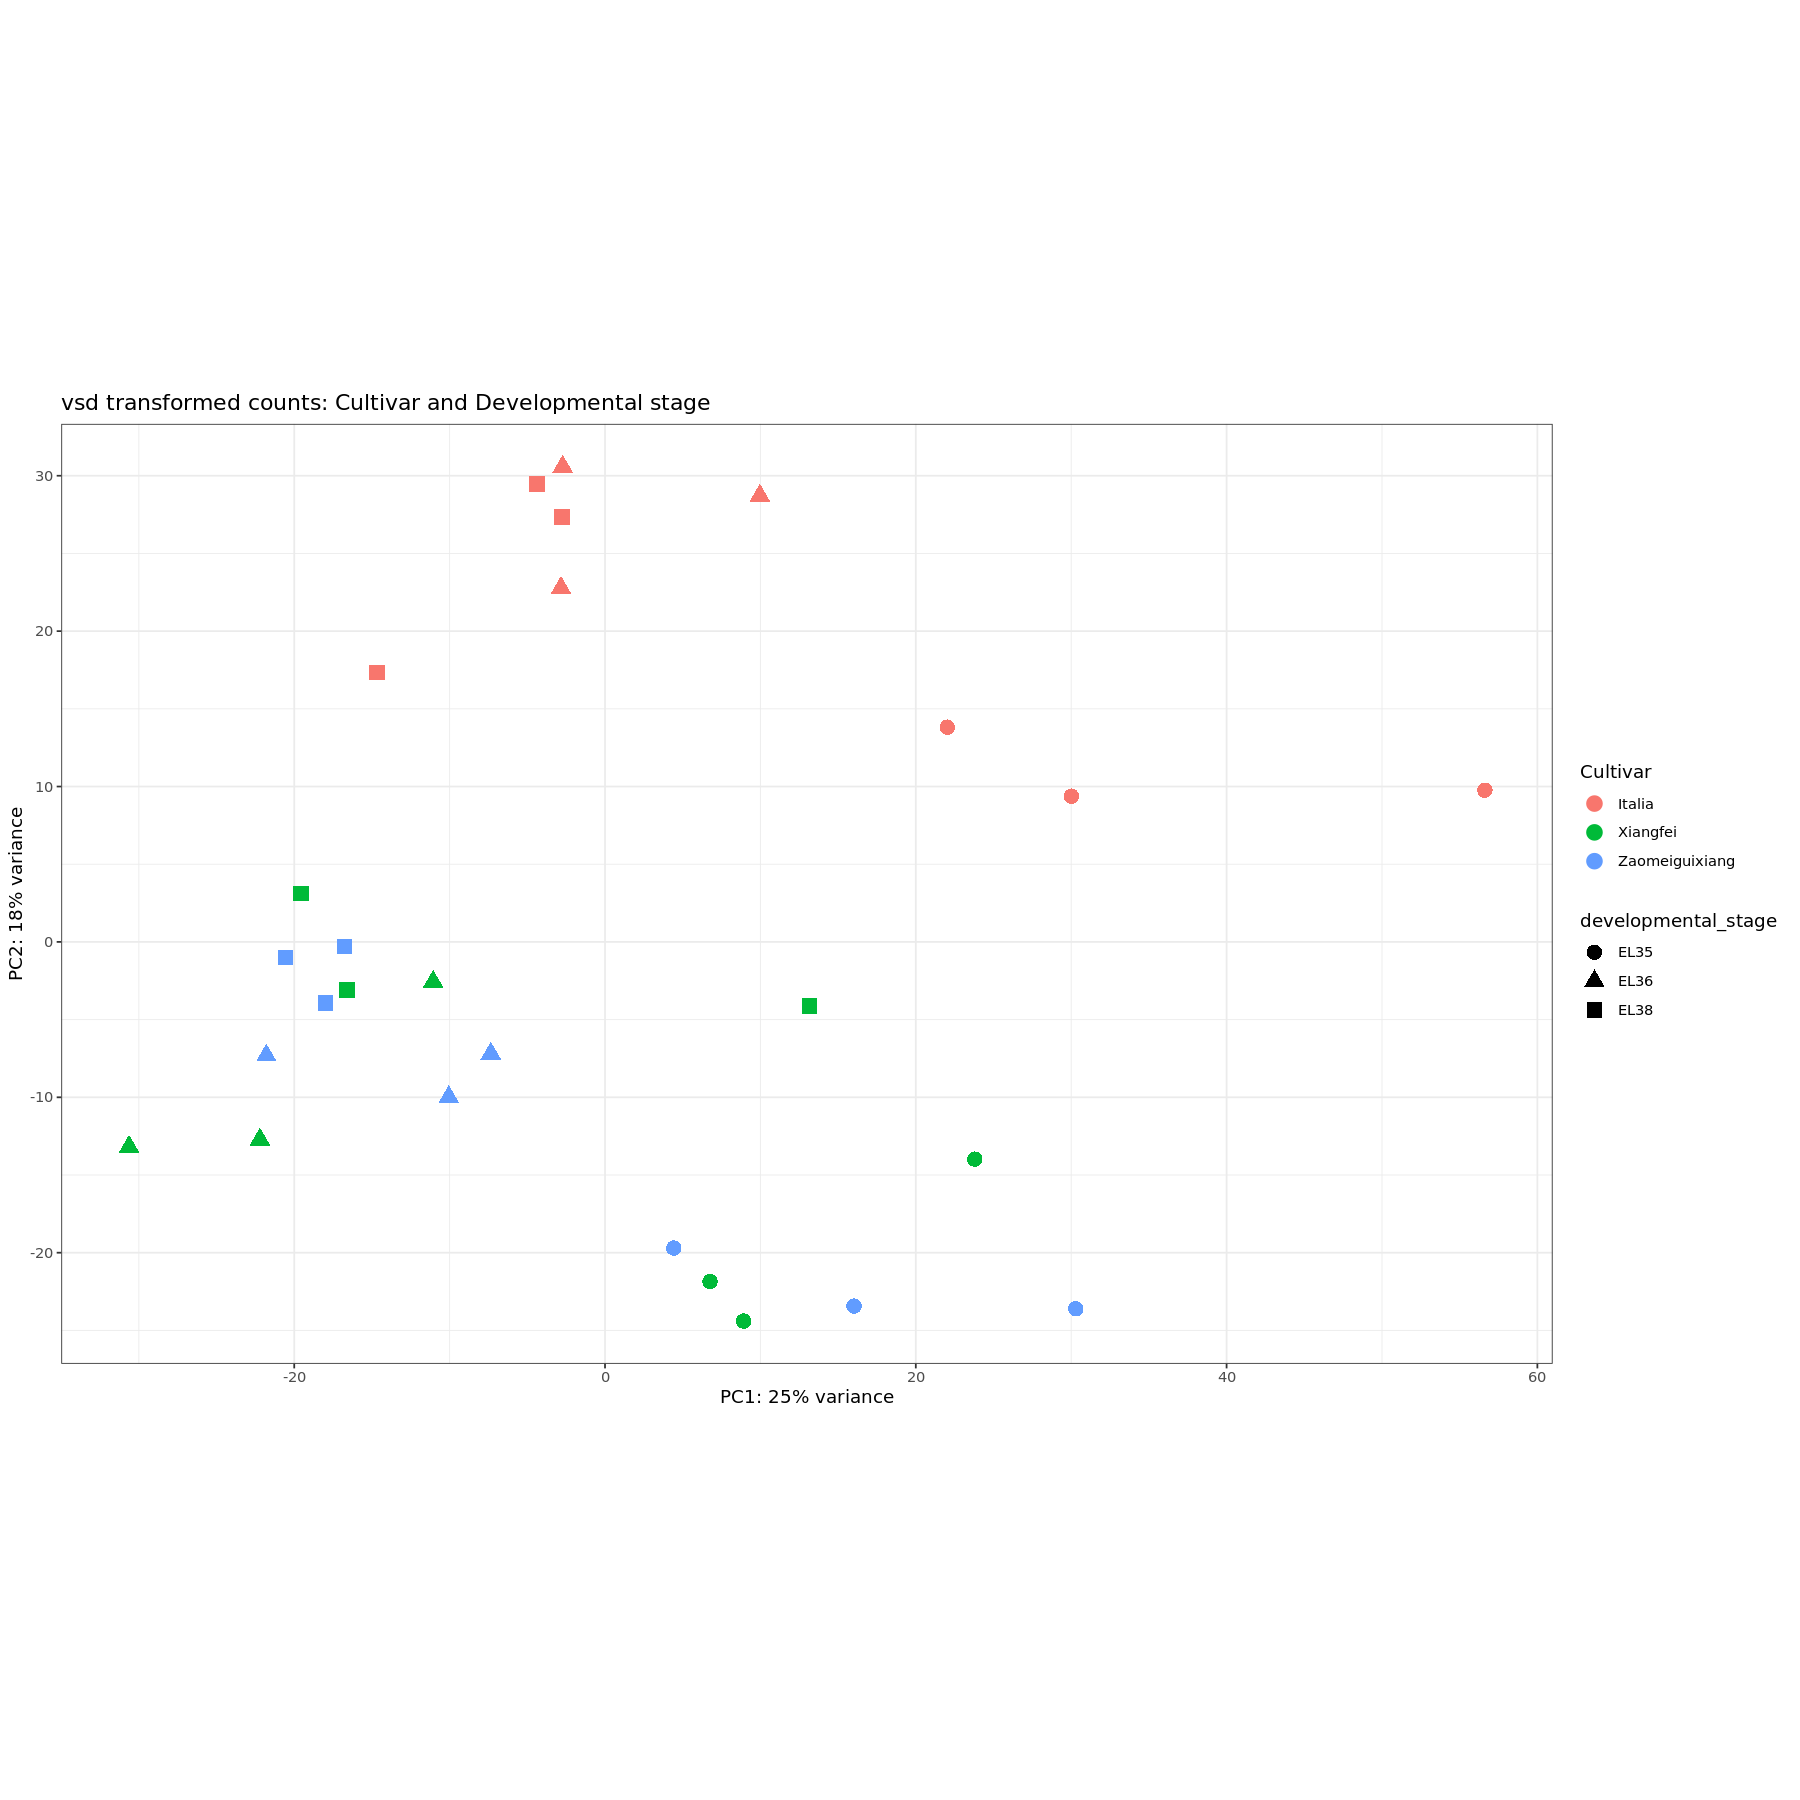

In [54]:
dds <- DESeqDataSetFromMatrix(
  countData = dge$counts,
  colData = targets,
  design = ~developmental_stage)
vsd <- vst(dds, blind=TRUE)
pcaData <- plotPCA(vsd, 
	intgroup=c("Cultivar","developmental_stage"), 
	returnData=TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))
ggplot(pcaData, aes(PC1, PC2, color=Cultivar, shape=developmental_stage)) +
  geom_point(size=4) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed() + ggtitle("vsd transformed counts: Cultivar and Developmental stage") +
  theme_bw() -> p
p

In [55]:
pdf(p, file="test")
dev.off()

Warning message:
“‘mode(width)’ differs between new and previous
	 ==> NOT changing ‘width’”
Warning message:
“‘length(width)’ differs between new and previous
	 ==> NOT changing ‘width’”


png 
  2

## PCA - 3D
```{r}
tmp <- btools::plotPCA3D(vsd, intgroup = "developmental_stage", ntop = 500,  returnData = TRUE)
percentVar3D <- round(100 * attr(tmp, "percentVar"))
plot_ly(tmp, x = ~PC1, y = ~PC2, z = ~PC3, color = ~developmental_stage) %>%
  add_markers() %>%
  layout(scene = list(xaxis = list(title = paste0("PC1: ",percentVar3D[1],"% variance")),
                      yaxis = list(title = paste0("PC2: ",percentVar3D[2],"% variance")),
                      zaxis = list(title = paste0("PC3: ",percentVar3D[3],"% variance"))))
```
### Activity

Generate a PCA 3D showing point colored by Cultivar (hint: modify the `intgroup` parameter)

In [13]:
tmp <- btools::plotPCA3D(vsd, intgroup = "developmental_stage", ntop = 500,  returnData = TRUE)
percentVar3D <- round(100 * attr(tmp, "percentVar"))
plot_ly(tmp, x = ~PC1, y = ~PC2, z = ~PC3, color = ~developmental_stage) %>%
  add_markers() %>%
  layout(scene = list(xaxis = list(title = paste0("PC1: ",percentVar3D[1],"% variance")),
                      yaxis = list(title = paste0("PC2: ",percentVar3D[2],"% variance")),
                      zaxis = list(title = paste0("PC3: ",percentVar3D[3],"% variance"))))





HTML widgets cannot be represented in plain text (need html)

# Differential Expression Analysis

## Design Overview

```{r}
targets
```
- 3 cutivars (2 chinese and 1 italian)
- 3 developmental stages from 
	- Veraison:
		+ El-35: Berries begin to colour and enlarge
		+ EL-36: Berries with intermediate sugar values
	- Harvest
		+ EL-38: Berries havest-ripe

## Comparisons (Exercise)

Q: Which biological questions do you want to answer with this design?

### A. Between developmental_stage, same Cultivar

1. X-EL35vsX-EL36
2. X-EL35vsX-EL38
3. X-EL36vsX-EL38
4. Y-EL35vsy-EL36
5. Y-EL35vsy-EL38
6. Y-EL36vsy-EL38
7. Z-EL35vsZ-EL36
8. Z-EL35vsZ-EL38
9. Z-EL36vsZ-EL38

### B. Between Cultivar, same developmental_stage

1. X-EL35vsY-EL35
2. X-EL35vsZ-EL35
3. Y-EL35vsZ-EL35
4. X-EL36vsY-EL36 
5. X-EL36vsZ-EL36
6. Y-EL36vsZ-EL36
7. X-EL38vsY-EL38
8. X-EL38vsZ-EL38
9. Y-EL38vsZ-EL38


__All samples will be filtered and normalized together.__


## Design Group-Mean Parametrization

Linear modeling and differential expression analysis in limma requires a design matrix to be specified. The design matrix records which treatment conditions were applied to each samples, and it also defines how the experimental effects are parametrized in the linear models. The experimental design for this study can be viewed as a one-way layout and the design matrix can be constructed by:


In [14]:
targets$group <- paste0(targets$Cultivar, ".", targets$developmental_stage)
f <-factor(targets$group,levels=unique(targets$group))
design <- model.matrix(~0+f)
colnames(design) <- unique(targets$group)

In [15]:
design

Xiangfei.EL35 Xiangfei.EL36 Xiangfei.EL38 Italia.EL35 Italia.EL36
1  1             0             0             0           0          
2  1             0             0             0           0          
3  1             0             0             0           0          
4  0             1             0             0           0          
5  0             1             0             0           0          
6  0             1             0             0           0          
7  0             0             1             0           0          
8  0             0             1             0           0          
9  0             0             1             0           0          
10 0             0             0             1           0          
11 0             0             0             1           0          
12 0             0             0             1           0          
13 0             0             0             0           1          
14 0             0             0             0           1          
15 0             0             0             0           1          
16 0             0             0             0           0          
17 0             0             0             0           0          
18 0             0             0             0           0          
19 0             0             0             0           0          
20 0             0             0             0           0          
21 0             0             0             0           0          
22 0             0             0             0           0          
23 0             0             0             0           0          
24 0             0             0             0           0          
25 0             0             0             0           0          
26 0             0             0             0           0          
27 0             0             0             0           0          
   Italia.EL38 Zaomeiguixiang.EL35 Zaomeiguixiang.EL36 Zaomeiguixiang.EL38
1  0           0                   0                   0                  
2  0           0                   0                   0                  
3  0           0                   0                   0                  
4  0           0                   0                   0                  
5  0           0                   0                   0                  
6  0           0                   0                   0                  
7  0           0                   0                   0                  
8  0           0                   0                   0                  
9  0           0                   0                   0                  
10 0           0                   0                   0                  
11 0           0                   0                   0                  
12 0           0                   0                   0                  
13 0           0                   0                   0                  
14 0           0                   0                   0                  
15 0           0                   0                   0                  
16 1           0                   0                   0                  
17 1           0                   0                   0                  
18 1           0                   0                   0                  
19 0           1                   0                   0                  
20 0           1                   0                   0                  
21 0           1                   0                   0                  
22 0           0                   1                   0                  
23 0           0                   1                   0                  
24 0           0                   1                   0                  
25 0           0                   0                   1                  
26 0           0                   0                   1                  
27 0           0                   0          

# Filtering
Genes that have very low counts across all the libraries should be removed prior to downstream analysis. This is justified on both biological and statistical grounds. From biological point of view, a gene must be expressed at some minimal level before it is likely to be translated into a protein or to be considered biologically important. From a statistical point of view, genes with consistently low counts are very unlikely be assessed as significantly DE because low counts do not provide enough statistical evidence for a reliable judgement to be made. Such genes can therefore be removed from the analysis without any loss of information. As a rule of thumb, we require that a gene have a count of at least 10 or so in at least some libraries before it is considered to be expressed in the study. In practice, the filtering is actually based on count-per-million (CPM) values so as to avoid favoring genes that are expressed in larger libraries over those expressed in smaller libraries. In edgeR, the filtering can be accomplished using a function that takes into account the library sizes and the experimental design:

In [16]:
# The next step is to remove rows that consistently have zero or very low counts.
keep <- filterByExpr(dge, design)
table(keep)
dge <- dge[keep,]

keep
FALSE  TRUE 
 6799 20429 

# Normalization for composition bias

Normalization by trimmed mean of M values (TMM) is performed by using the calcNormFactors function, which returns the DGEList argument with only the norm.factors changed. It calculates a set of normalization factors, one for each sample, to eliminate composition biases between libraries. The product of these factors and the library sizes defines the effective library size, which replaces the original library size in all downstream analyses. The normalization factors of all the libraries multiply to unity. A normalization factor below one indicates that a small number of high count genes are monopolizing the sequencing, causing the counts for other genes to be lower than would be usual given the library size. As a result, the effective library size will be scaled down for that sample. Here we see, for example, tha GSM3737302, GSM3737303, GSM3737308 samples (there are more) have low normalization factors. This is a sign that these samples contain a number of very highly upregulated genes. Note. In general, we find TMM normalization to be satisfactory for almost all well-designed mRNA gene expression experiments. Single-cell RNA-seq is an exception, for which specialized normalization methods are needed (Lun, Bach, and Marioni 2016). Another, less common, type of study requiring special treatment is that with global differential expression, with more than half of the genome differentially expressed between experimental conditions in the same direction (Wu et al. 2013). Global differential expression should generally be avoided in well designed experiments. When it can’t be avoided, then some normalization reference such as spike-ins needs to be built into the experiment for reliable normalization to be done (Risso et al. 2014).


In [17]:
dge <- calcNormFactors(dge, method = "TMM")

# Defining each treatment combination as a group
We now consider experiments with more than one experimental factor, but in which every
combination of experiment conditions can potentially have a unique effect. For example,
suppose that an experiment has been conducted on 3 different cultivars at three
developmental stages with all samples obtained from independent subjects. 
The data frame targets describes the treatment conditions applied to each sample.
Here we provide a contrast matrix for the contrast `development stage`:

In [18]:
## Contrast Matrices
cont.matrix.EL <- makeContrasts(
  Xiangfei.EL35vsXiangfei.EL36=Xiangfei.EL35-Xiangfei.EL36, 
  Xiangfei.EL35vsXiangfei.EL38=Xiangfei.EL35-Xiangfei.EL38, 
  Xiangfei.EL36vsXiangfei.EL38=Xiangfei.EL36-Xiangfei.EL38, 
  Italia.EL35vsItalia.EL36=Italia.EL35-Italia.EL36,
  Italia.EL35vsItalia.EL38=Italia.EL35-Italia.EL38,
  Italia.EL36vsItalia.EL38=Italia.EL36-Italia.EL38,
  Zaomeiguixiang.EL35vsZaomeiguixiang.EL36=Zaomeiguixiang.EL35-Zaomeiguixiang.EL36,
  Zaomeiguixiang.EL35vsZaomeiguixiang.EL38=Zaomeiguixiang.EL35-Zaomeiguixiang.EL38,
  Zaomeiguixiang.EL36vsZaomeiguixiang.EL38=Zaomeiguixiang.EL36-Zaomeiguixiang.EL38,
  levels=design)

In [56]:
head(cont.matrix.EL)

Contrasts
Levels          Xiangfei.EL35vsXiangfei.EL36 Xiangfei.EL35vsXiangfei.EL38
  Xiangfei.EL35  1                            1                          
  Xiangfei.EL36 -1                            0                          
  Xiangfei.EL38  0                           -1                          
  Italia.EL35    0                            0                          
  Italia.EL36    0                            0                          
  Italia.EL38    0                            0                          
               Contrasts
Levels          Xiangfei.EL36vsXiangfei.EL38 Italia.EL35vsItalia.EL36
  Xiangfei.EL35  0                            0                      
  Xiangfei.EL36  1                            0                      
  Xiangfei.EL38 -1                            0                      
  Italia.EL35    0                            1                      
  Italia.EL36    0                           -1                      
  Italia.EL38    0                            0                      
               Contrasts
Levels          Italia.EL35vsItalia.EL38 Italia.EL36vsItalia.EL38
  Xiangfei.EL35  0                        0                      
  Xiangfei.EL36  0                        0                      
  Xiangfei.EL38  0                        0                      
  Italia.EL35    1                        0                      
  Italia.EL36    0                        1                      
  Italia.EL38   -1                       -1                      
               Contrasts
Levels          Zaomeiguixiang.EL35vsZaomeiguixiang.EL36
  Xiangfei.EL35 0                                       
  Xiangfei.EL36 0                                       
  Xiangfei.EL38 0                                       
  Italia.EL35   0                                       
  Italia.EL36   0                                       
  Italia.EL38   0                                       
               Contrasts
Levels          Zaomeiguixiang.EL35vsZaomeiguixiang.EL38
  Xiangfei.EL35 0                                       
  Xiangfei.EL36 0                                       
  Xiangfei.EL38 0                                       
  Italia.EL35   0                                       
  Italia.EL36   0                                       
  Italia.EL38   0                                       
               Contrasts
Levels          Zaomeiguixiang.EL36vsZaomeiguixiang.EL38
  Xiangfei.EL35 0                                       
  Xiangfei.EL36 0                                       
  Xiangfei.EL38 0                                       
  Italia.EL35   0                                       
  Italia.EL36   0                                       
  Italia.EL38   0

# Differential expression

## Linear modeling with limma-voom

We se voom() <a href="#ref10">[10]</a> to convert the read counts to log2-cpm, with associated weights, ready for linear modelling. The voom plot is used to check the mean-variance relationship of the expression data, after fitting a linear model. A scatterplot of residual-variances vs average log-expression is created. The plot is especially useful for examining the mean-variance trend.  It can be seen from this plot that the variance is no longer dependent on the mean expression level.

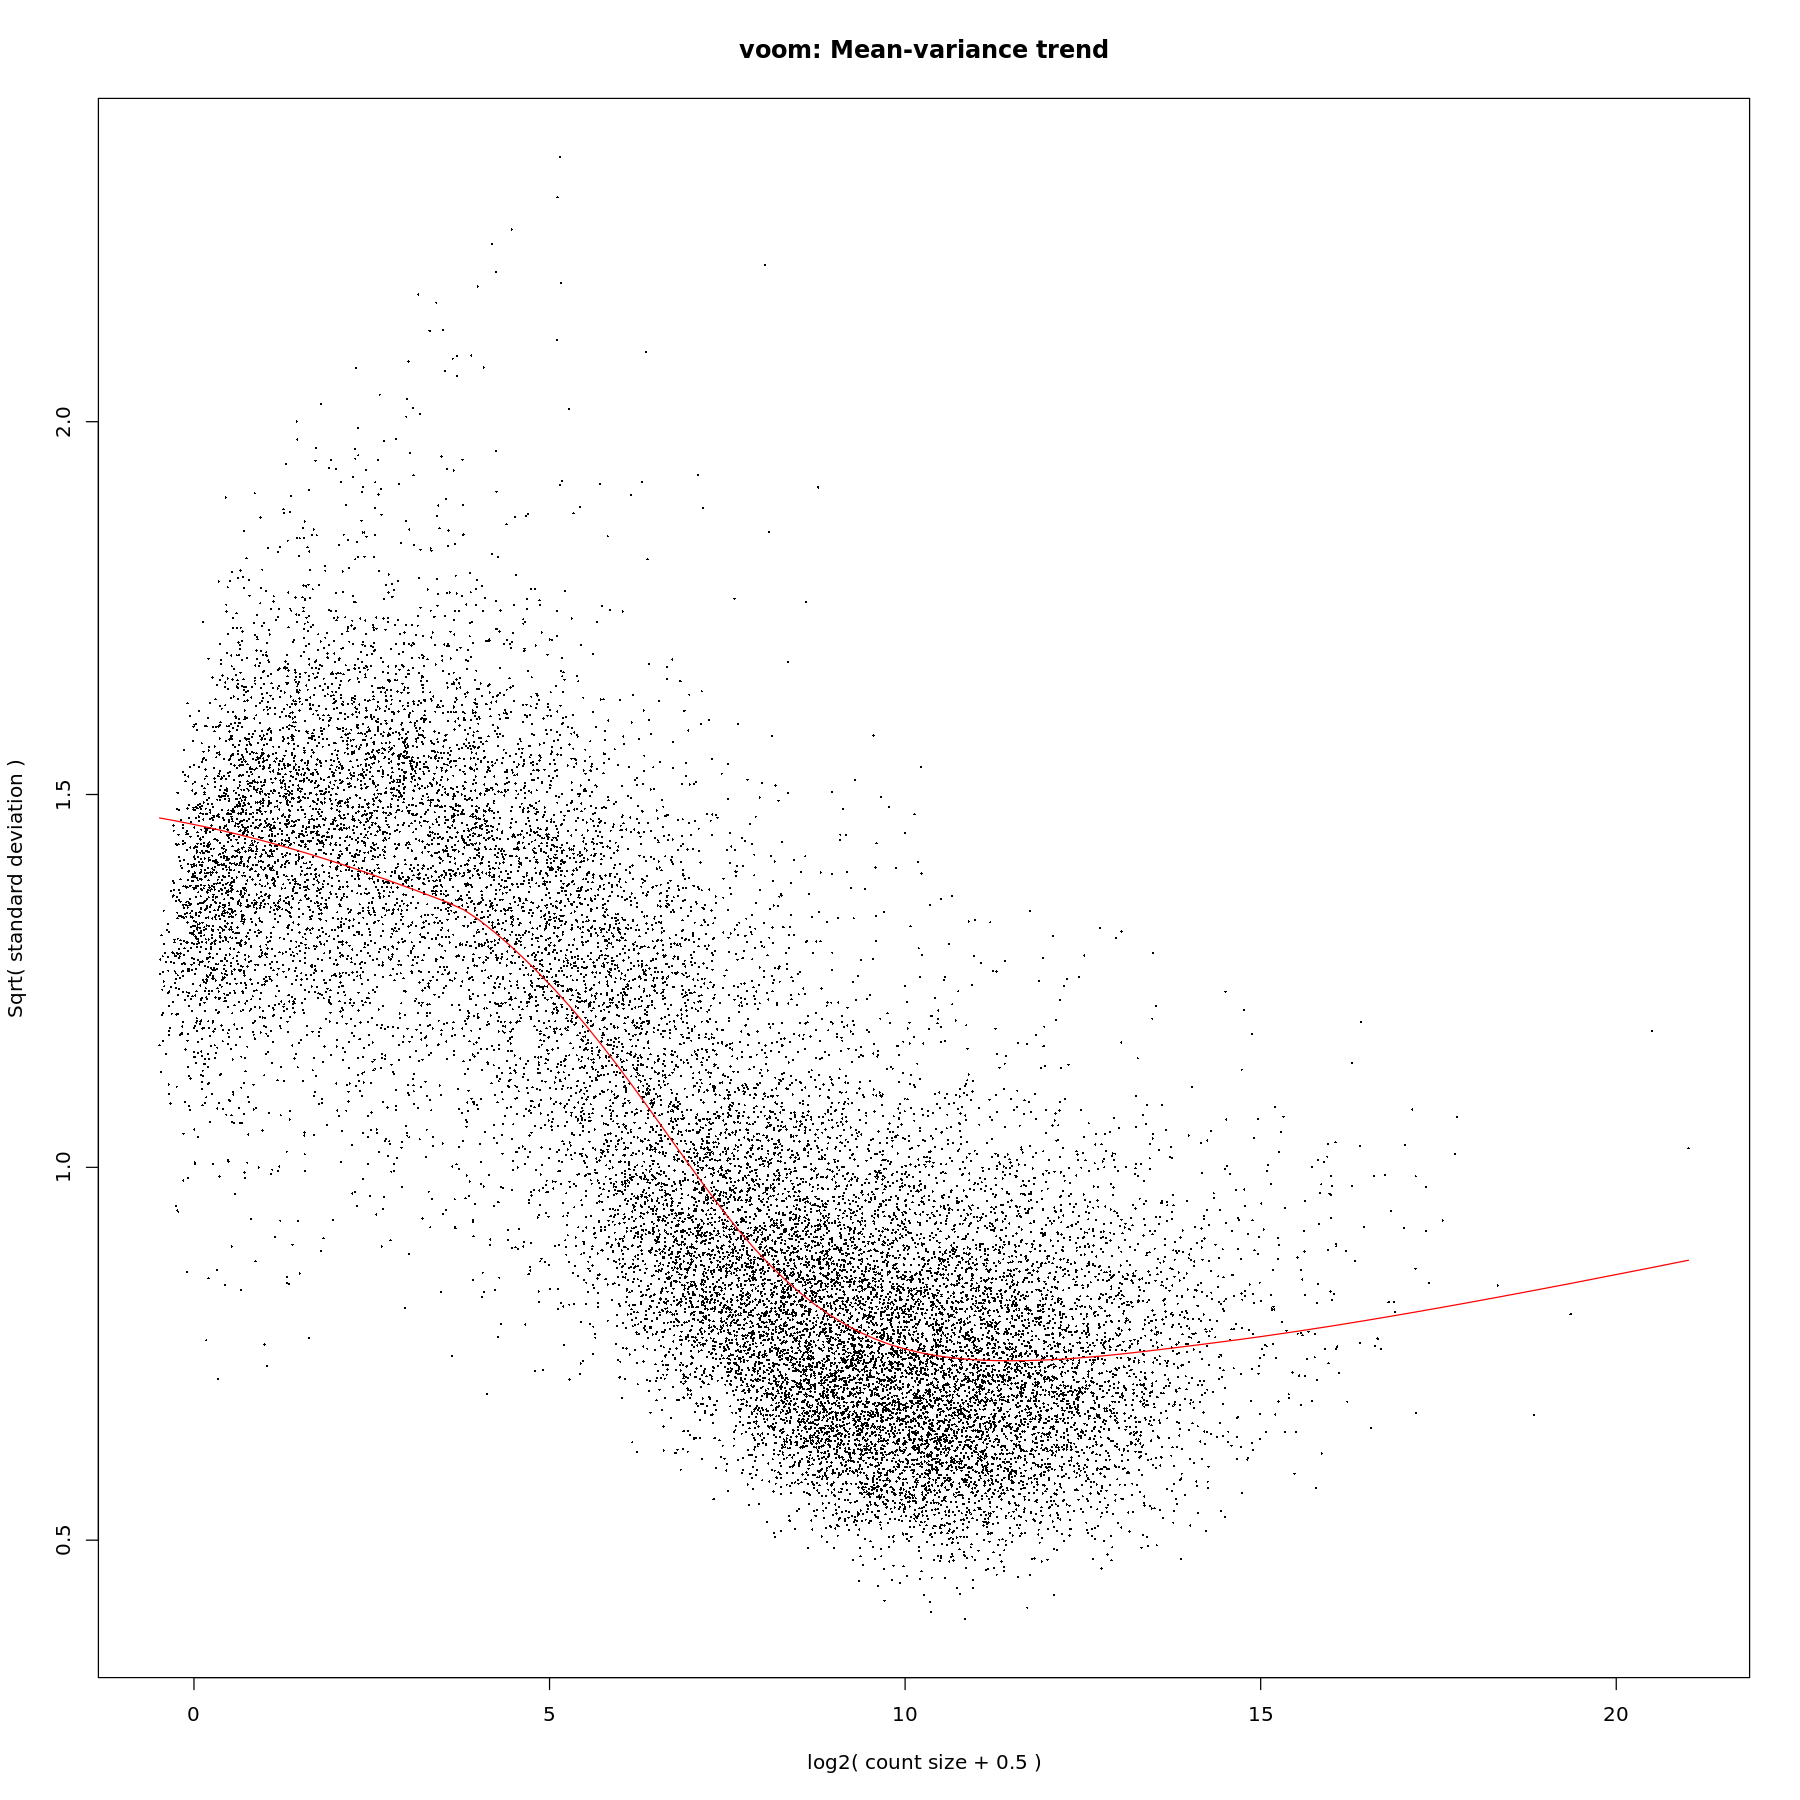

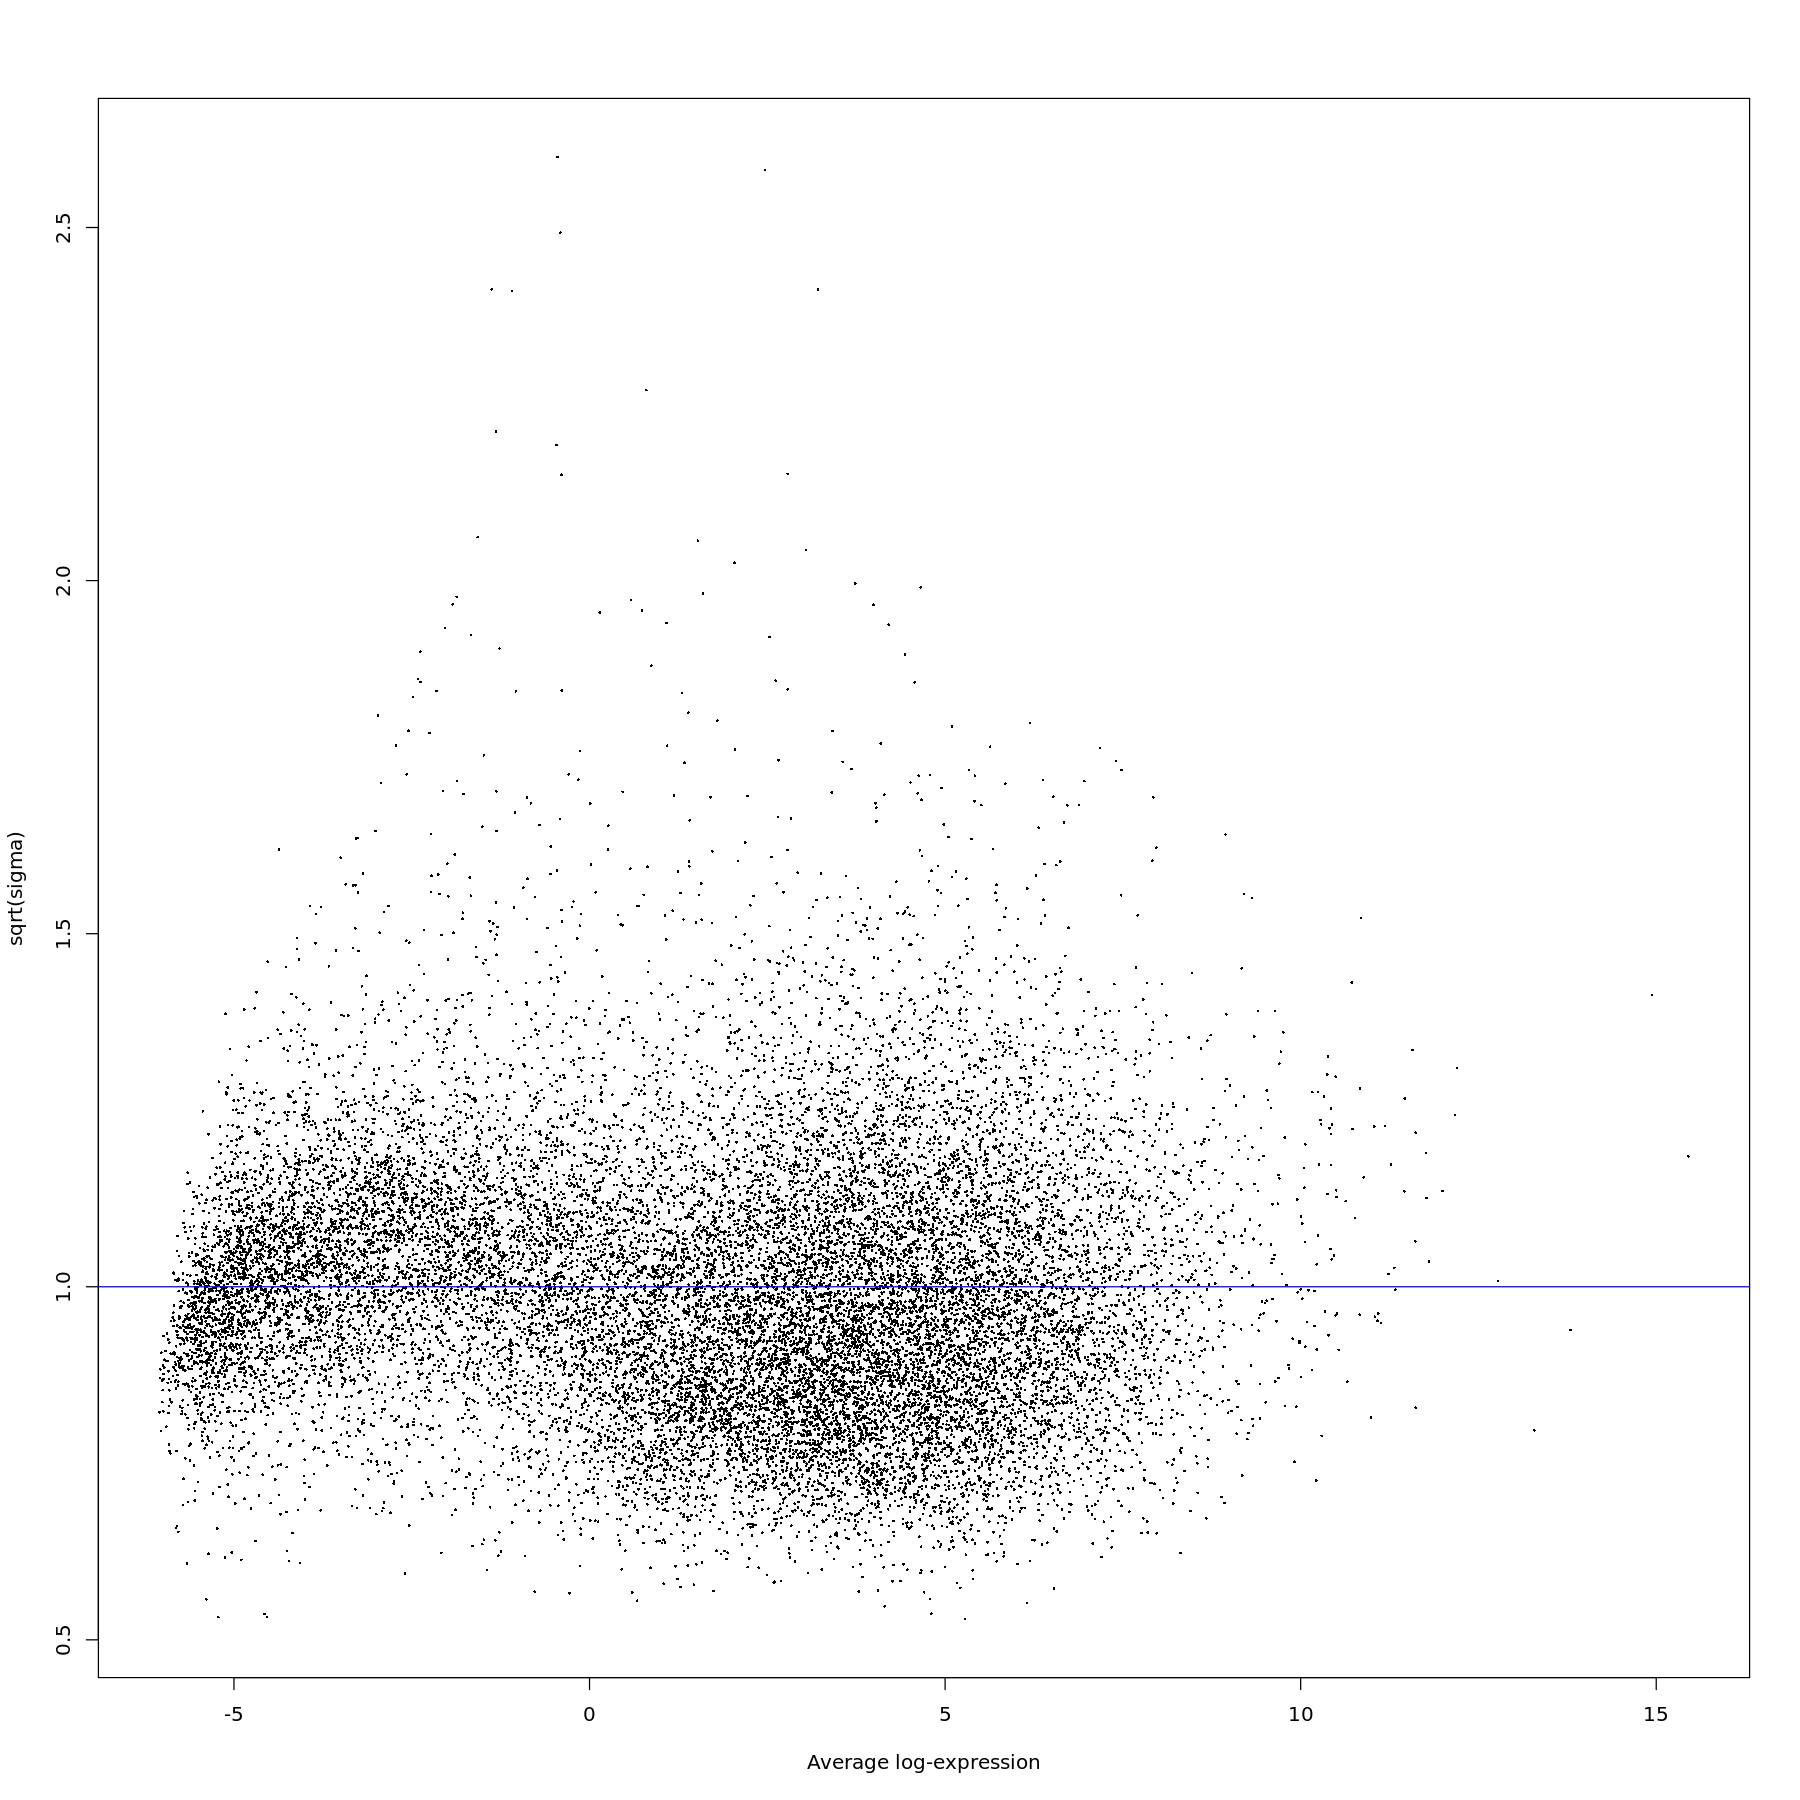

In [19]:
cont.matrix <- cont.matrix.EL
v <- voom(dge, design, plot = TRUE)
fit_voom <- lmFit(v, design)
plotSA(fit_voom)
abline(a=1, b=0, col="blue")
fit_voom2 <- contrasts.fit(fit_voom, cont.matrix)
fit_voom2 <- eBayes(fit_voom2)
fit_voom2$Genes <- rownames(fc$counts)

## Developmental stages (EL) contrasts
```{r}
Xiangfei.EL35vsXiangfei.EL36 <- topTable(fit_voom2, coef=1,number = Inf, adjust.method = "BH", sort.by = "P")
Xiangfei.EL35vsXiangfei.EL36 %>% rownames_to_column() %>% arrange(-logFC,P.Value) %>% head()
fit_voom2_ELs_decideTest_separate <- summary(decideTests(fit_voom2, method="separate"))
nice.col <- brewer.pal(6,name="Dark2")
stripchart(v$E["VIT_07s0005g03420",]~targets$group,
	vertical=TRUE,las=2,cex.axis=0.8,pch=16,cex=1.3,col=nice.col,
	method="jitter",ylab="Normalised log2 expression",main="VIT_07s0005g03420")
```

rowname           logFC    AveExpr    t         P.Value      adj.P.Val   
1 VIT_07s0095g00550 7.712018  0.1830227 10.327731 2.703965e-10 6.008180e-07
2 VIT_06s0009g03120 7.666485  2.7917350  9.577901 1.170277e-09 1.328199e-06
3 VIT_11s0052g01650 7.155291 -2.6185237  8.434400 1.254465e-08 9.240781e-06
4 VIT_18s0001g09550 7.114677  3.1339884  8.909312 4.587970e-09 4.075115e-06
5 VIT_02s0025g03000 6.848862  0.7162690  6.716831 6.115191e-07 1.705201e-04
6 VIT_01s0011g05110 6.802424  6.6428832  7.338808 1.431602e-07 6.048240e-05
  B        
1 13.302511
2 11.984594
3  9.814341
4 10.739678
5  6.182989
6  7.548512

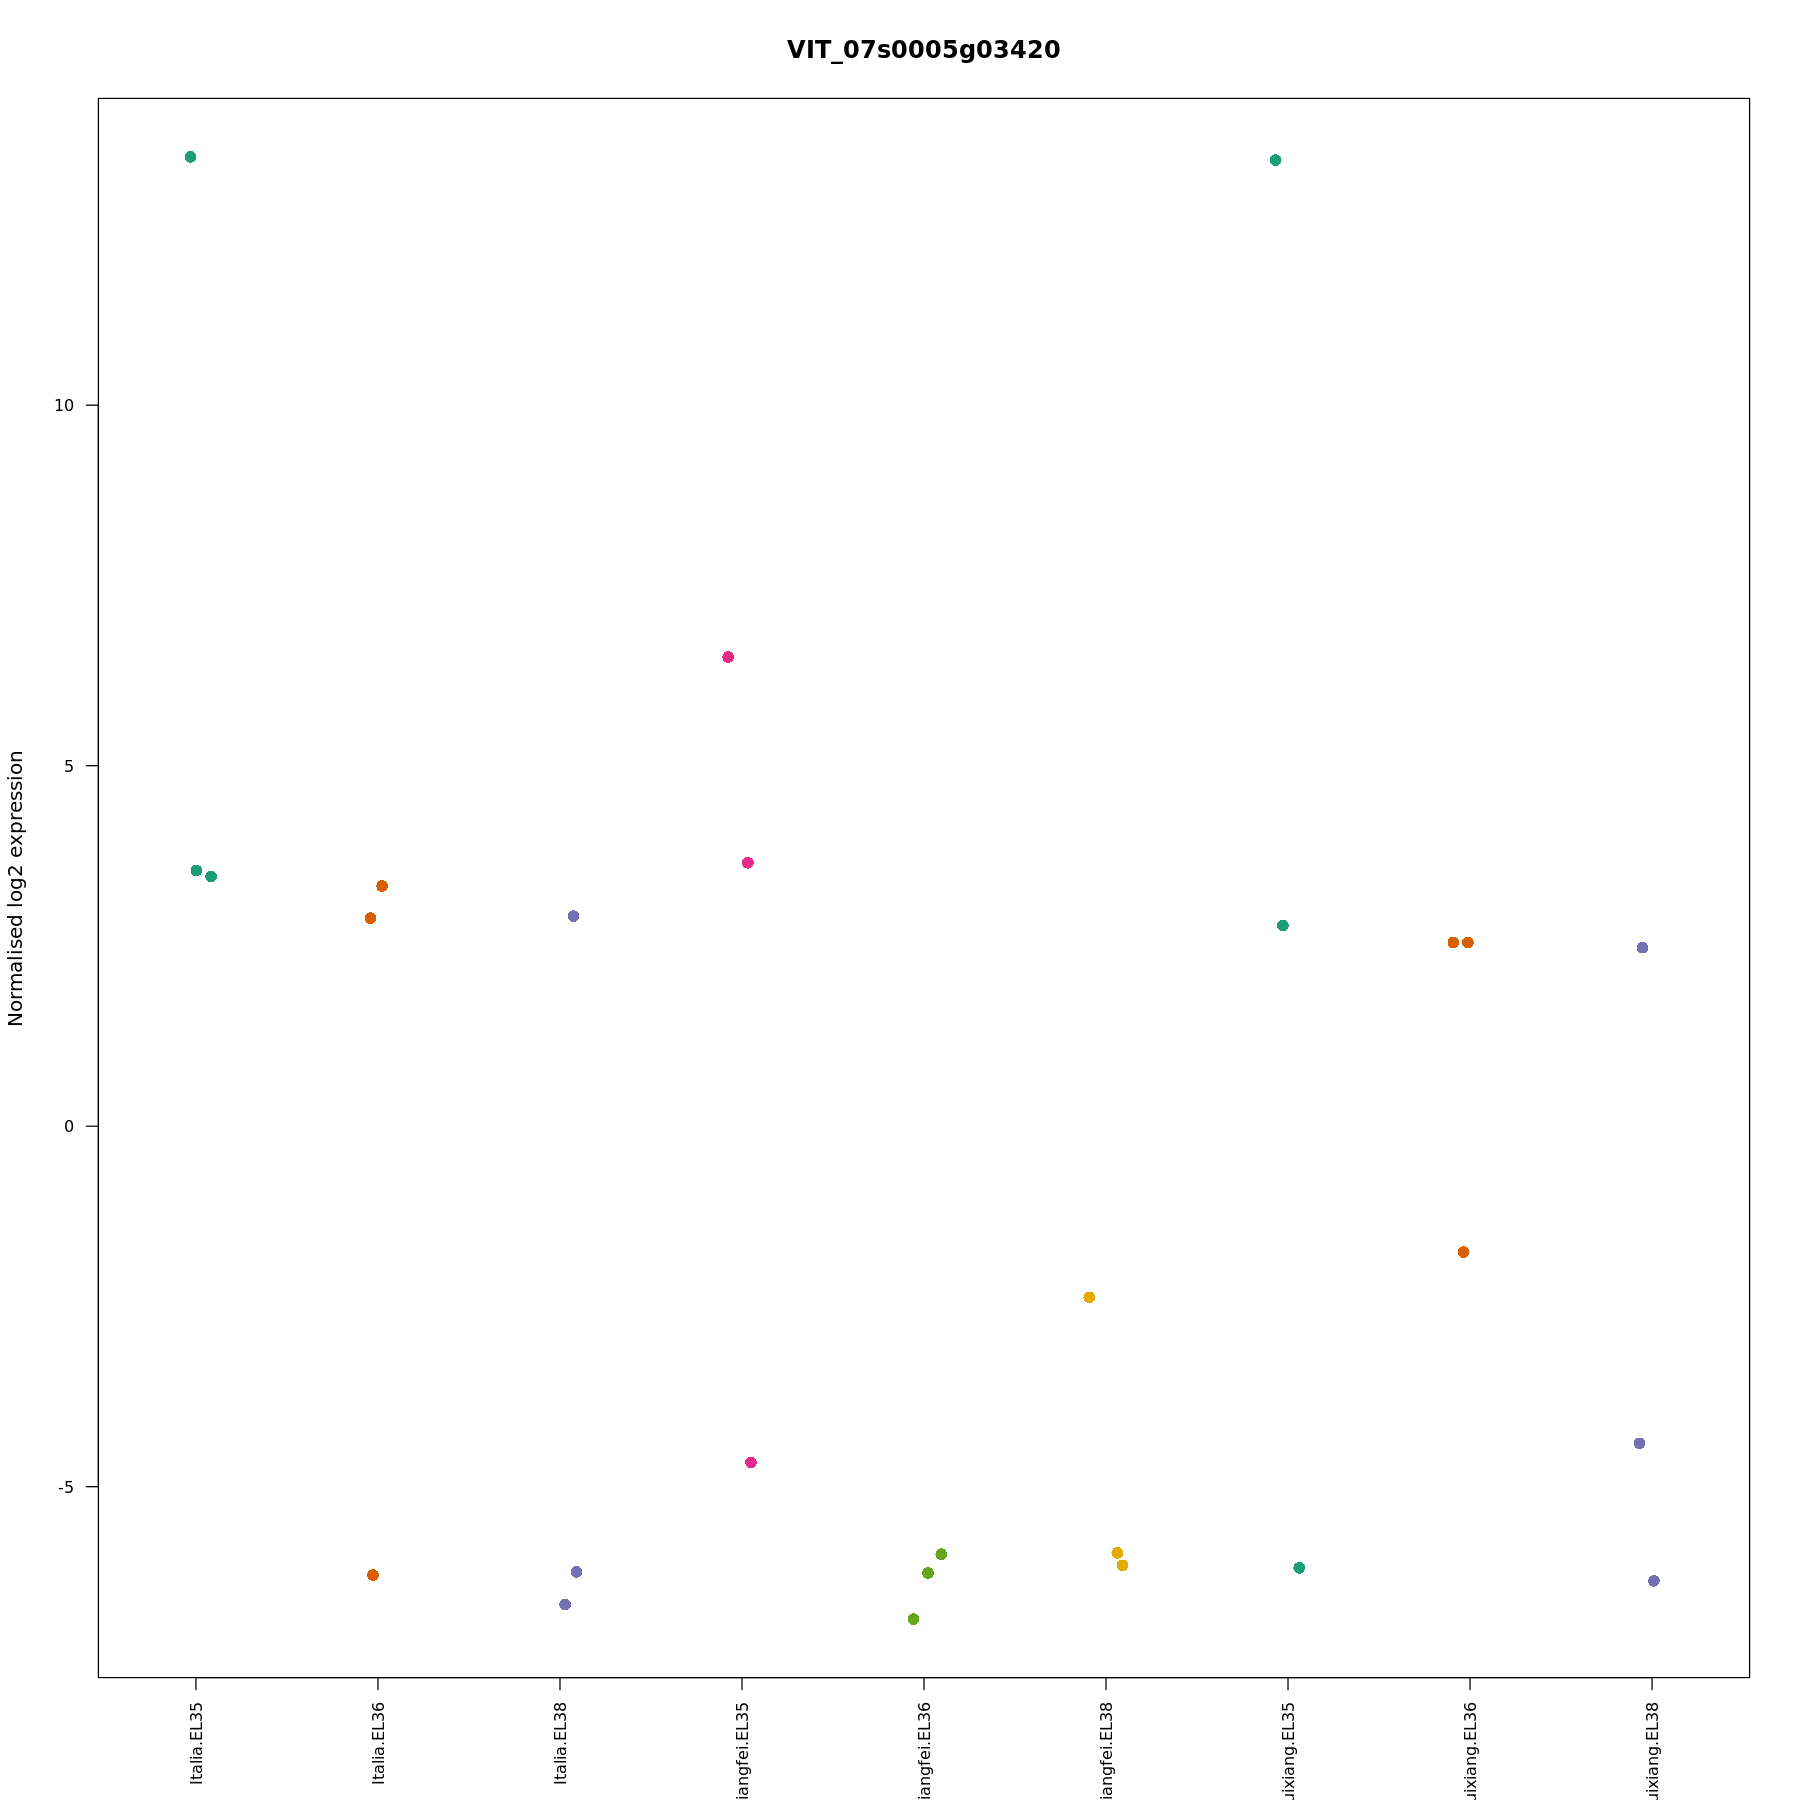

In [58]:
Xiangfei.EL35vsXiangfei.EL36 <- topTable(fit_voom2, coef=1,number = Inf, adjust.method = "BH", sort.by = "P")
Xiangfei.EL35vsXiangfei.EL36 %>% rownames_to_column() %>% arrange(-logFC,P.Value) %>% head()
fit_voom2_ELs_decideTest_separate <- summary(decideTests(fit_voom2, method="separate"))
nice.col <- brewer.pal(6,name="Dark2")
stripchart(v$E["VIT_07s0005g03420",]~targets$group,
	vertical=TRUE,las=2,cex.axis=0.8,pch=16,cex=1.3,col=nice.col,
	method="jitter",ylab="Normalised log2 expression",main="VIT_07s0005g03420")

## Cultivar contrasts - voom
```{r}
cont.matrix.cultivar <- makeContrasts(
  Xiangfei.EL35vsItalia.EL35=Xiangfei.EL35-Italia.EL35,
  Xiangfei.EL36vsItalia.EL36=Xiangfei.EL36-Italia.EL36,
  Xiangfei.EL38vsItalia.EL38=Xiangfei.EL38-Italia.EL38,
  Xiangfei.EL35vsZaomeiguixiang.EL35=Xiangfei.EL35-Zaomeiguixiang.EL35,
  Xiangfei.EL36vsZaomeiguixiang.EL36=Xiangfei.EL36-Zaomeiguixiang.EL36,
  Xiangfei.EL38vsZaomeiguixiang.EL38=Xiangfei.EL38-Zaomeiguixiang.EL38,
  Italia.EL35vsZaomeiguixiang.EL35=Italia.EL35-Zaomeiguixiang.EL35,
  Italia.EL36vsZaomeiguixiang.EL36=Italia.EL36-Zaomeiguixiang.EL36,
  Italia.EL38vsZaomeiguixiang.EL38=Italia.EL38-Zaomeiguixiang.EL38,
  levels=design)
```

In [22]:
cont.matrix.cultivar <- makeContrasts(
  Xiangfei.EL35vsItalia.EL35=Xiangfei.EL35-Italia.EL35,
  Xiangfei.EL36vsItalia.EL36=Xiangfei.EL36-Italia.EL36,
  Xiangfei.EL38vsItalia.EL38=Xiangfei.EL38-Italia.EL38,
  Xiangfei.EL35vsZaomeiguixiang.EL35=Xiangfei.EL35-Zaomeiguixiang.EL35,
  Xiangfei.EL36vsZaomeiguixiang.EL36=Xiangfei.EL36-Zaomeiguixiang.EL36,
  Xiangfei.EL38vsZaomeiguixiang.EL38=Xiangfei.EL38-Zaomeiguixiang.EL38,
  Italia.EL35vsZaomeiguixiang.EL35=Italia.EL35-Zaomeiguixiang.EL35,
  Italia.EL36vsZaomeiguixiang.EL36=Italia.EL36-Zaomeiguixiang.EL36,
  Italia.EL38vsZaomeiguixiang.EL38=Italia.EL38-Zaomeiguixiang.EL38,
  levels=design)

In [23]:
cont.matrix <- cont.matrix.cultivar
fit_voom2 <- contrasts.fit(fit_voom, cont.matrix)
fit_voom2 <- eBayes(fit_voom2)
fit_voom2$Genes <- rownames(fc$counts)
Xiangfei.EL35vsItalia.EL35 <- topTable(fit_voom2, coef=1,number = Inf, adjust.method = "BH", sort.by = "P")
Xiangfei.EL35vsItalia.EL35 %>% rownames_to_column() %>% arrange(-logFC,P.Value) %>% head()
fit_voom2_cutltivars_decideTest_separate <- summary(decideTests(fit_voom2, method="separate"))

rowname           logFC    AveExpr    t        P.Value      adj.P.Val   
1 VIT_11s0052g01650 9.518316 -4.3724655 8.076051 2.693465e-08 3.668319e-05
2 VIT_02s0025g03000 9.147673  0.2486453 5.962741 3.753832e-06 9.129409e-04
3 VIT_06s0009g03120 8.877865  2.6391427 6.135577 2.457086e-06 7.069834e-04
4 VIT_03s0038g02010 8.658546 -3.3456325 6.107376 2.632454e-06 7.170454e-04
5 VIT_19s0014g03180 8.468297 -2.1687693 6.396308 1.304340e-06 4.611484e-04
6 VIT_07s0095g00550 8.375760 -0.4394077 7.620523 7.440547e-08 7.900885e-05
  B       
1 7.477017
2 3.778769
3 4.230104
4 4.065296
5 4.536291
6 7.063188

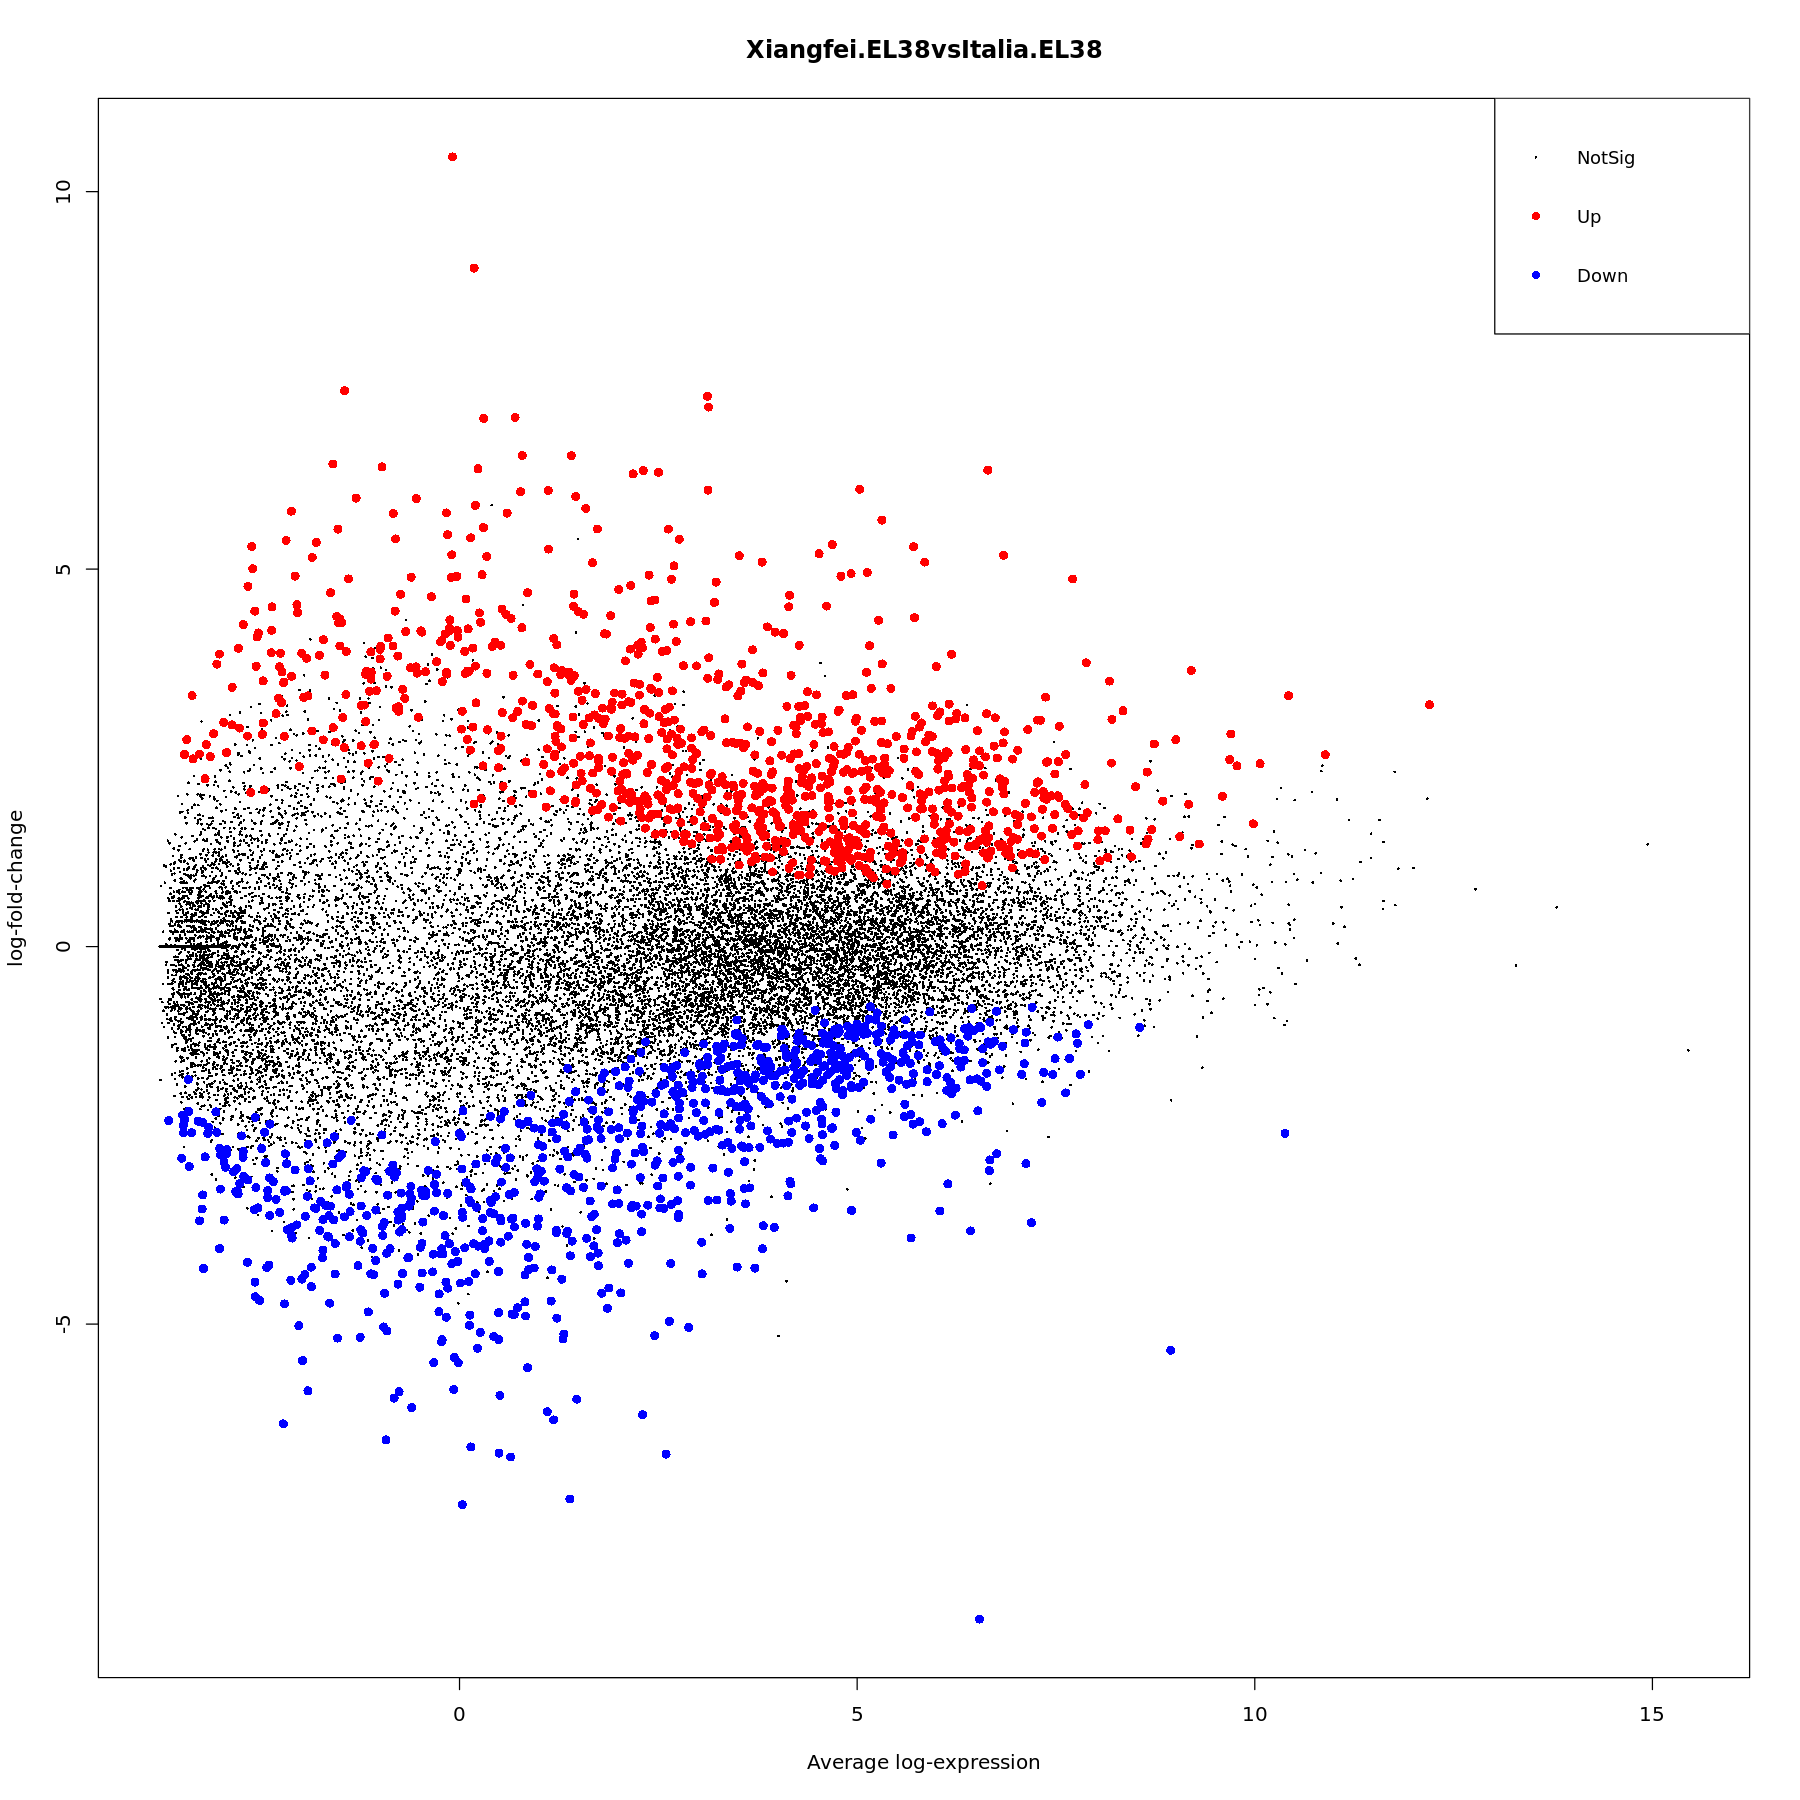

In [49]:
dt=decideTests(fit_voom2)
plotMD(fit_voom2, column=3,status=dt[,3])

# Differential expression: limma-trend
If the sequencing depth is reasonably consistent across the RNA samples, then the simplest and most
robust approach to differential exis to use limma-trend. This approach will usually work well if the
ratio of the largest library size to the smallest is not more than about 3-fold.
In the limma-trend approach, the counts are converted to logCPM values using edgeR’s cpm
function:

In [24]:
logCPM <- cpm(dge, log=TRUE, prior.count=3)

__N.B.__ The prior count is used here to damp down the variances of logarithms of low counts.

The logCPM values can then be used in any standard limma pipeline, using the trend=TRUE argument when running eBayes or treat.

### Activity
- Create a contrast matrix ( named `cont.matrix.cultivar` ) which allows the selection of the differential expressed genes for all three cultivars in any stage, i.e.Xiangfei.EL35vsItalia.EL35, Xiangfei.EL35-Italia.EL35, Xiangfei.EL35vsZaomeiguixiang.EL35, etc..
- Use either the limma-voom or the following limma-trend procedure to retrieve a list of differential expressed genes for each contrast.

## Cultivar contrasts - trend 
```{r}
cont.matrix <- cont.matrix.cultivar
fit_voom <- lmFit(logCPM, design)
fit_voom2 <- contrasts.fit(fit_voom, cont.matrix)
fit_voom2 <- eBayes(fit_voom2, trend = TRUE)
fit_voom2$Genes <- rownames(fc$counts)
Xiangfei.EL35vsItalia.EL35 <- topTable(fit_voom2, coef=1,number = Inf, adjust.method = "BH", sort.by = "P")
Xiangfei.EL35vsItalia.EL35 %>% rownames_to_column() %>% arrange(-logFC,P.Value) %>% write_tsv("tT_Xiangfei.EL35vsItalia.EL35_trend.txt")
fit_voom2_cutltivars_decideTest_separate <- summary(decideTests(fit_voom2, method="separate"))

```

In [25]:
cont.matrix <- cont.matrix.cultivar
fit_voom <- lmFit(logCPM, design)
fit_voom2 <- contrasts.fit(fit_voom, cont.matrix)
fit_voom2 <- eBayes(fit_voom2, trend = TRUE)
fit_voom2$Genes <- rownames(fc$counts)
Xiangfei.EL35vsItalia.EL35 <- topTable(fit_voom2, coef=1,number = Inf, adjust.method = "BH", sort.by = "P")
Xiangfei.EL35vsItalia.EL35 %>% rownames_to_column() %>% arrange(-logFC,P.Value) %>% write_tsv("tT_Xiangfei.EL35vsItalia.EL35_trend.txt")
fit_voom2_cutltivars_decideTest_separate <- summary(decideTests(fit_voom2, method="separate"))

### plot of individual genes of interest
Before following up on the DE genes with further lab work, it is recommended to have a look at the expression levels of the individual samples for the genes of interest. We can quickly look at grouped expression using stripchart. We can use either the normalised log expression values in the voom object (`v$E`) or `logCPM`.


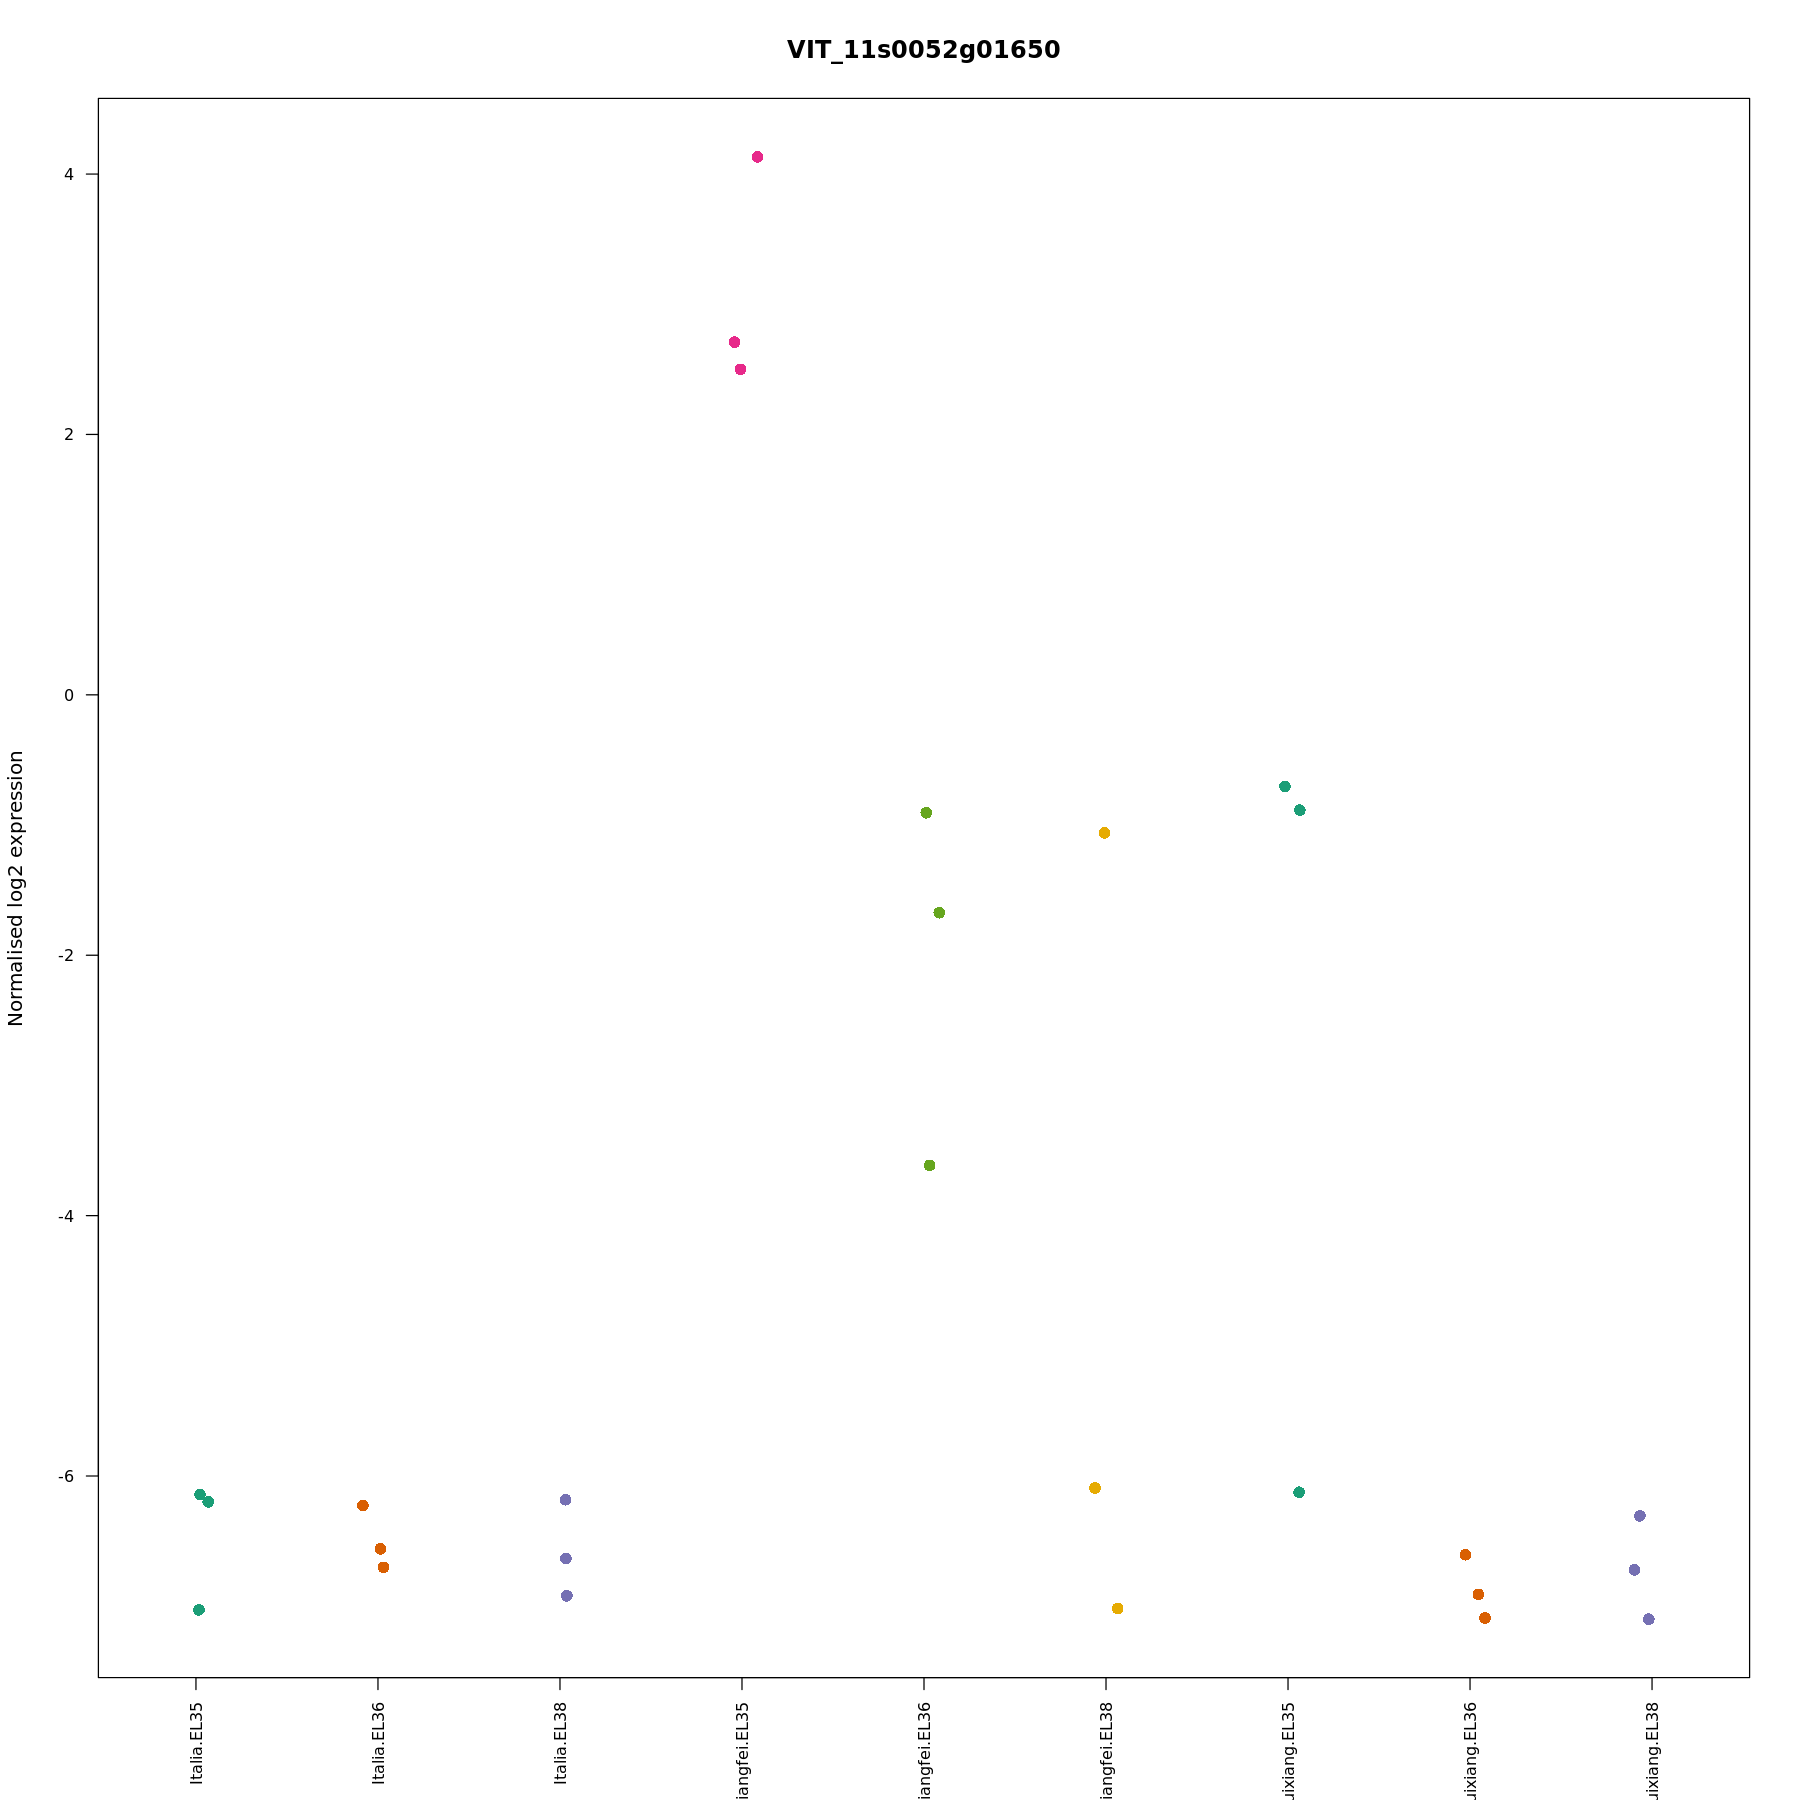

In [26]:
nice.col <- brewer.pal(6,name="Dark2")
my_gene="VIT_11s0052g01650"
stripchart(v$E[my_gene,]~targets$group,
  vertical=TRUE,las=2,cex.axis=0.8,pch=16,cex=1.3,col=nice.col,
  method="jitter",ylab="Normalised log2 expression",main=my_gene)

#### Activity
Create a barplot showing  the number of up and down regulated genes in all contrasts.

#### Hint
Use the the table returned by `summary(decideTests(fit_voom2, method="separate"))` as data object and either the `barplot()` function or ggplot2 `geom_bar(stat="identity")` layer for build the plot.

## P-value distribution

Warning message:
“Removed 2 rows containing missing values (geom_bar).”


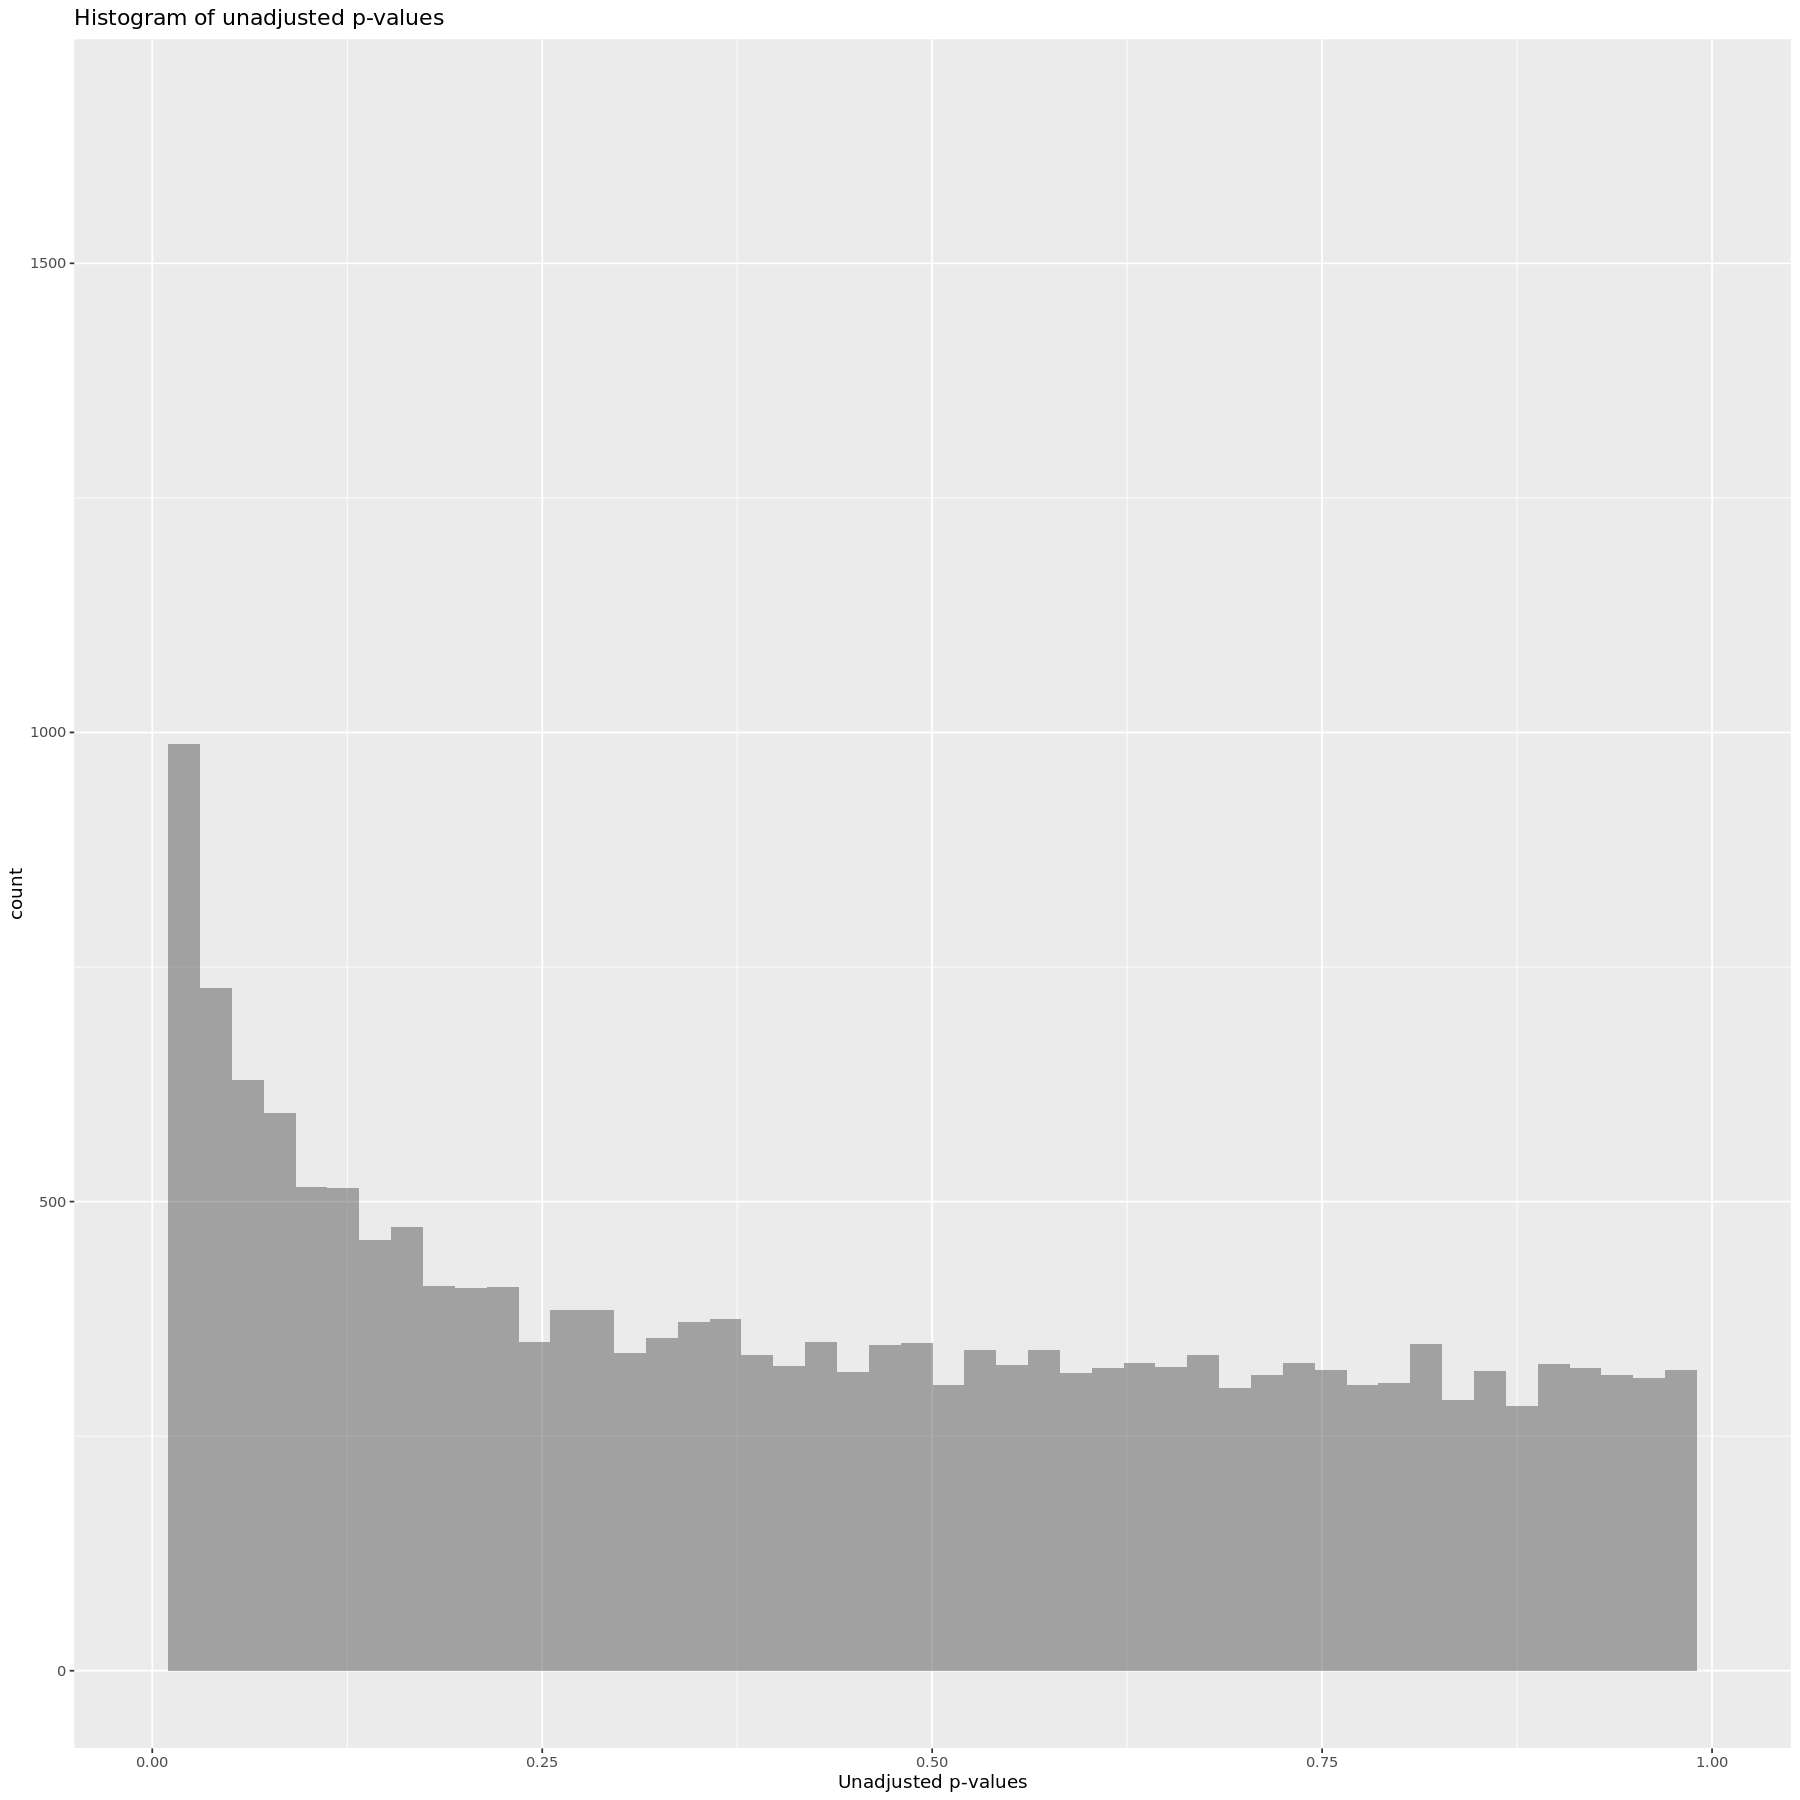

In [27]:
ggplot(Xiangfei.EL35vsItalia.EL35[!is.na(Xiangfei.EL35vsItalia.EL35$P.Value),], aes(x = P.Value)) +
    geom_histogram(alpha=.5, position='identity', bins = 50) +
    labs(title='Histogram of unadjusted p-values') +
    xlab('Unadjusted p-values') +
    xlim(c(0, 1.0005)) 

## Volcano plot

A volcano plot displays log fold changes on the x-axis versus a measure of statistical significance on the y-axis(Here $-log_{10}Pvalue$).

       Xiangfei.EL35vsItalia.EL35 Xiangfei.EL36vsItalia.EL36
Down                          292                        627
NotSig                      19450                      18882
Up                            687                        920
       Xiangfei.EL38vsItalia.EL38 Xiangfei.EL35vsZaomeiguixiang.EL35
Down                          821                                171
NotSig                      18629                              20152
Up                            979                                106
       Xiangfei.EL36vsZaomeiguixiang.EL36 Xiangfei.EL38vsZaomeiguixiang.EL38
Down                                  602                                933
NotSig                              19442                              18623
Up                                    385                                873
       Italia.EL35vsZaomeiguixiang.EL35 Italia.EL36vsZaomeiguixiang.EL36
Down                                684                              873
NotSig                    

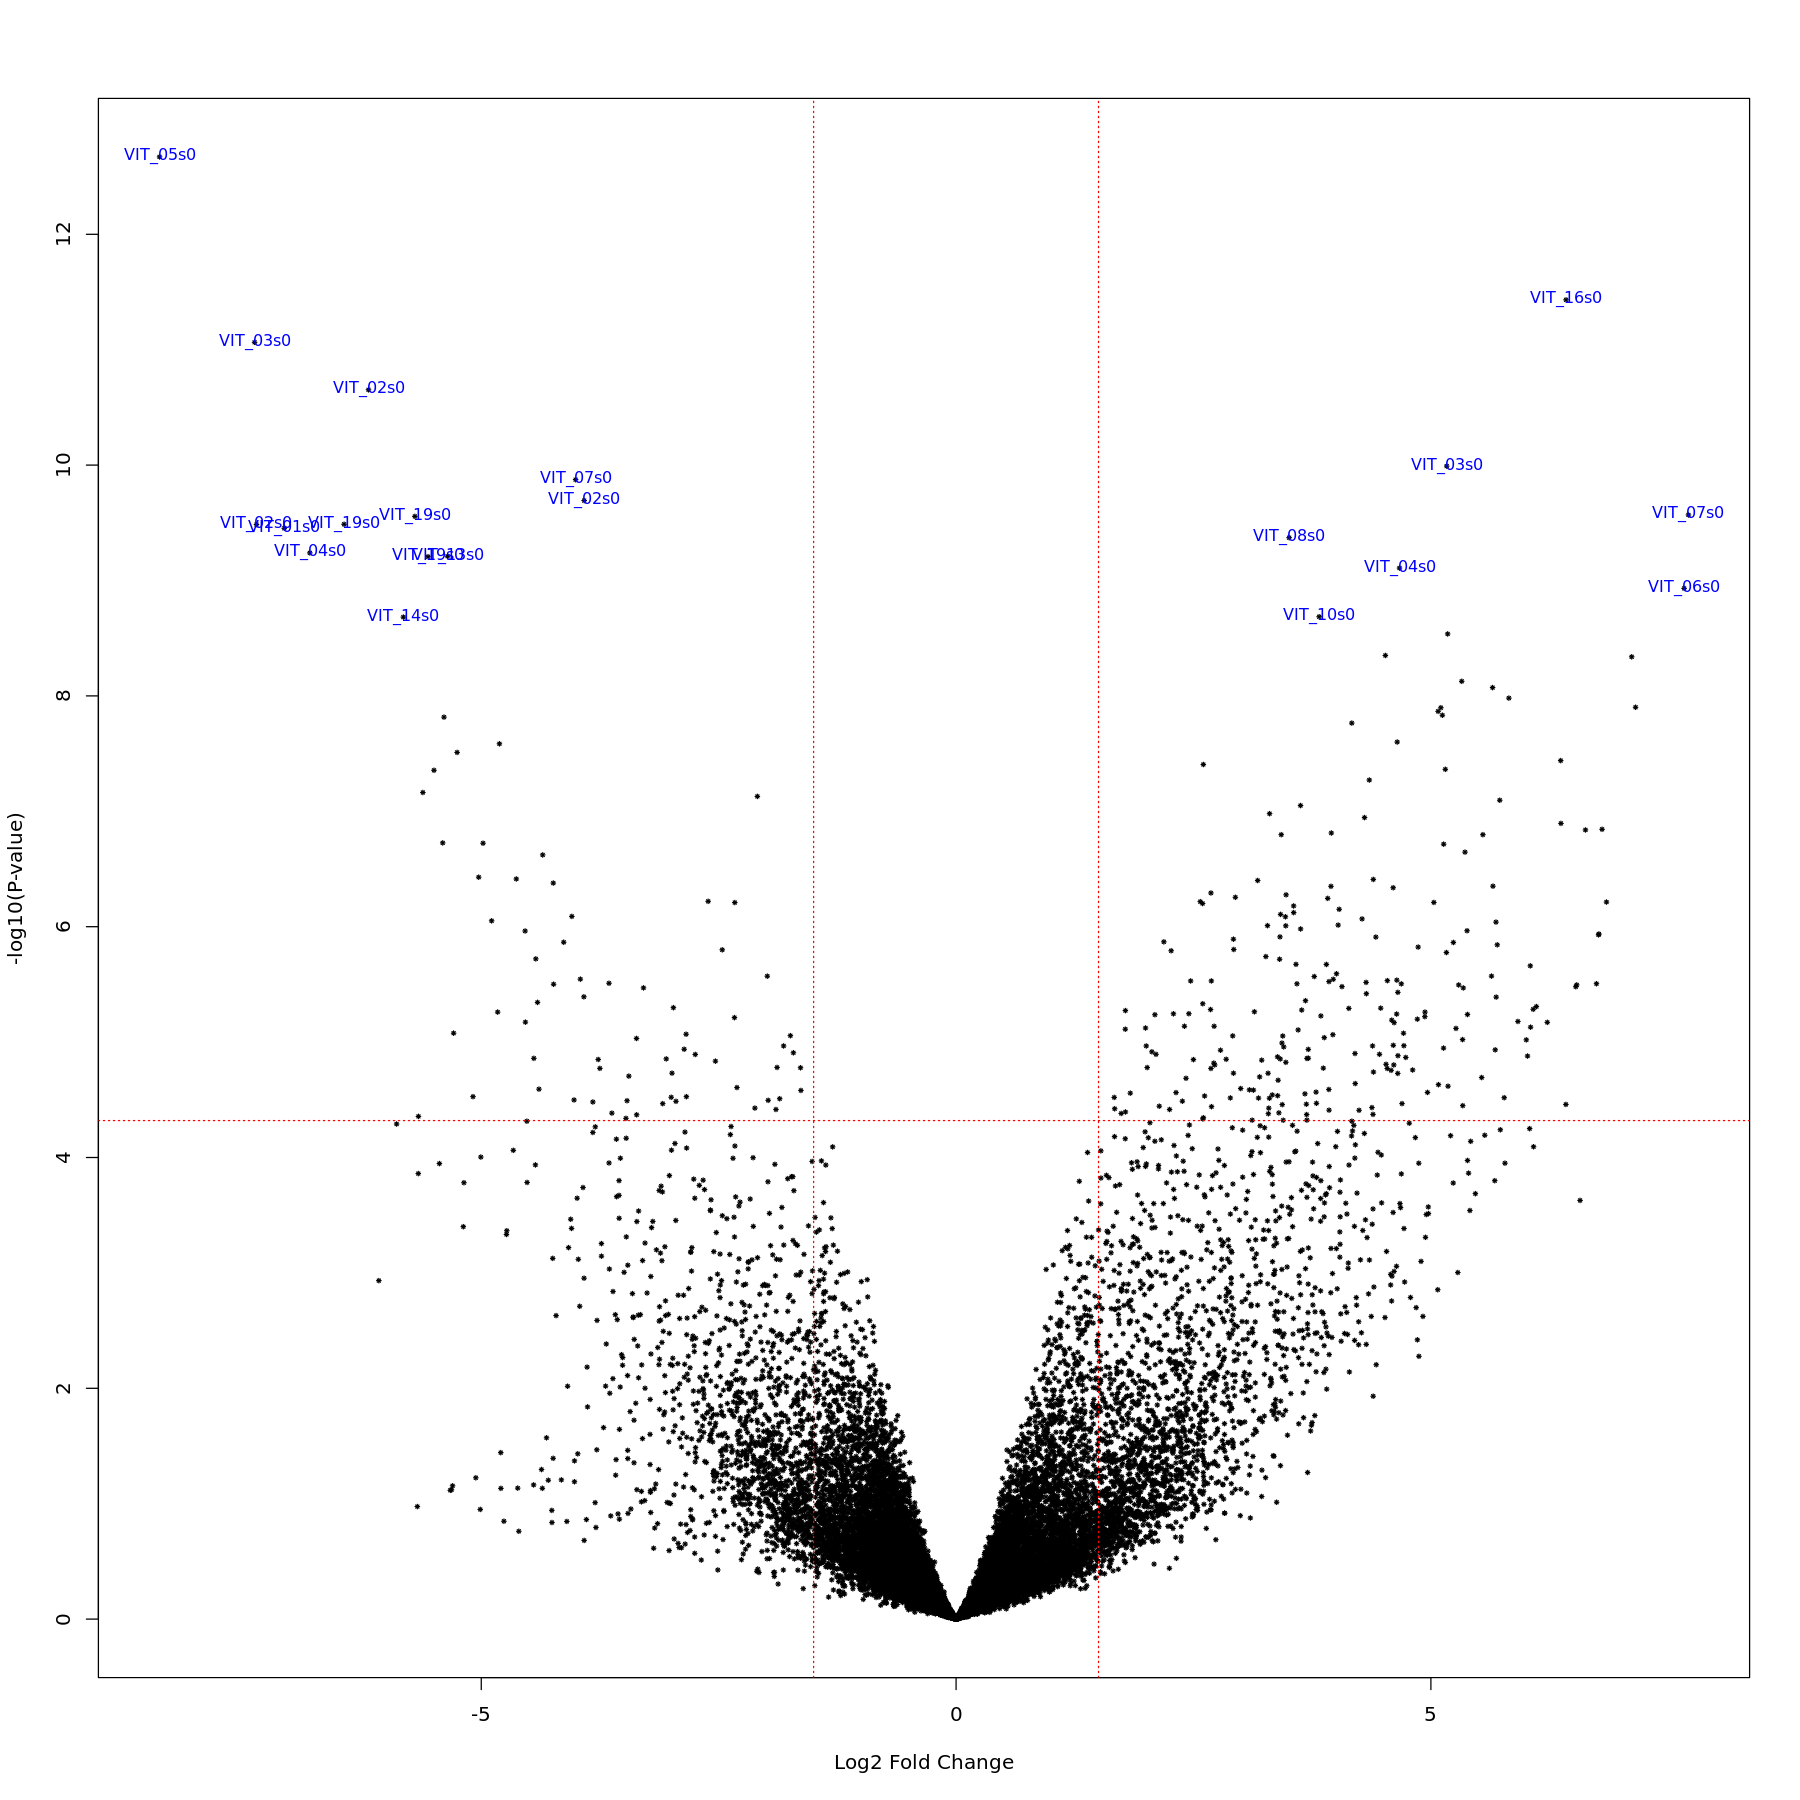

In [28]:
results_voom <- decideTests(fit_voom2)
summary(decideTests(fit_voom2, lfc=1, p.value=0.05))
volcanoplot(fit_voom2, coef =1, highlight=20, names=rownames(fit_voom2), main="", pch=8, cex=0.35)
abline(h = -4.32, v = -1.5, col = "red", lty = 3); abline(h = 4.32, v = 1.5, col = "red", lty = 3)


## Heat map
Heatmaps are a way to display differential expression results. To create a heatmap, we  select the first n DE genes log2-counts-per-million (logCPM) values.


A heat map can then be produced by the coolmap function which clusters genes by correlation (highly correlated genes are closest) and clusters samples based on Euclidean distance between the expression values.


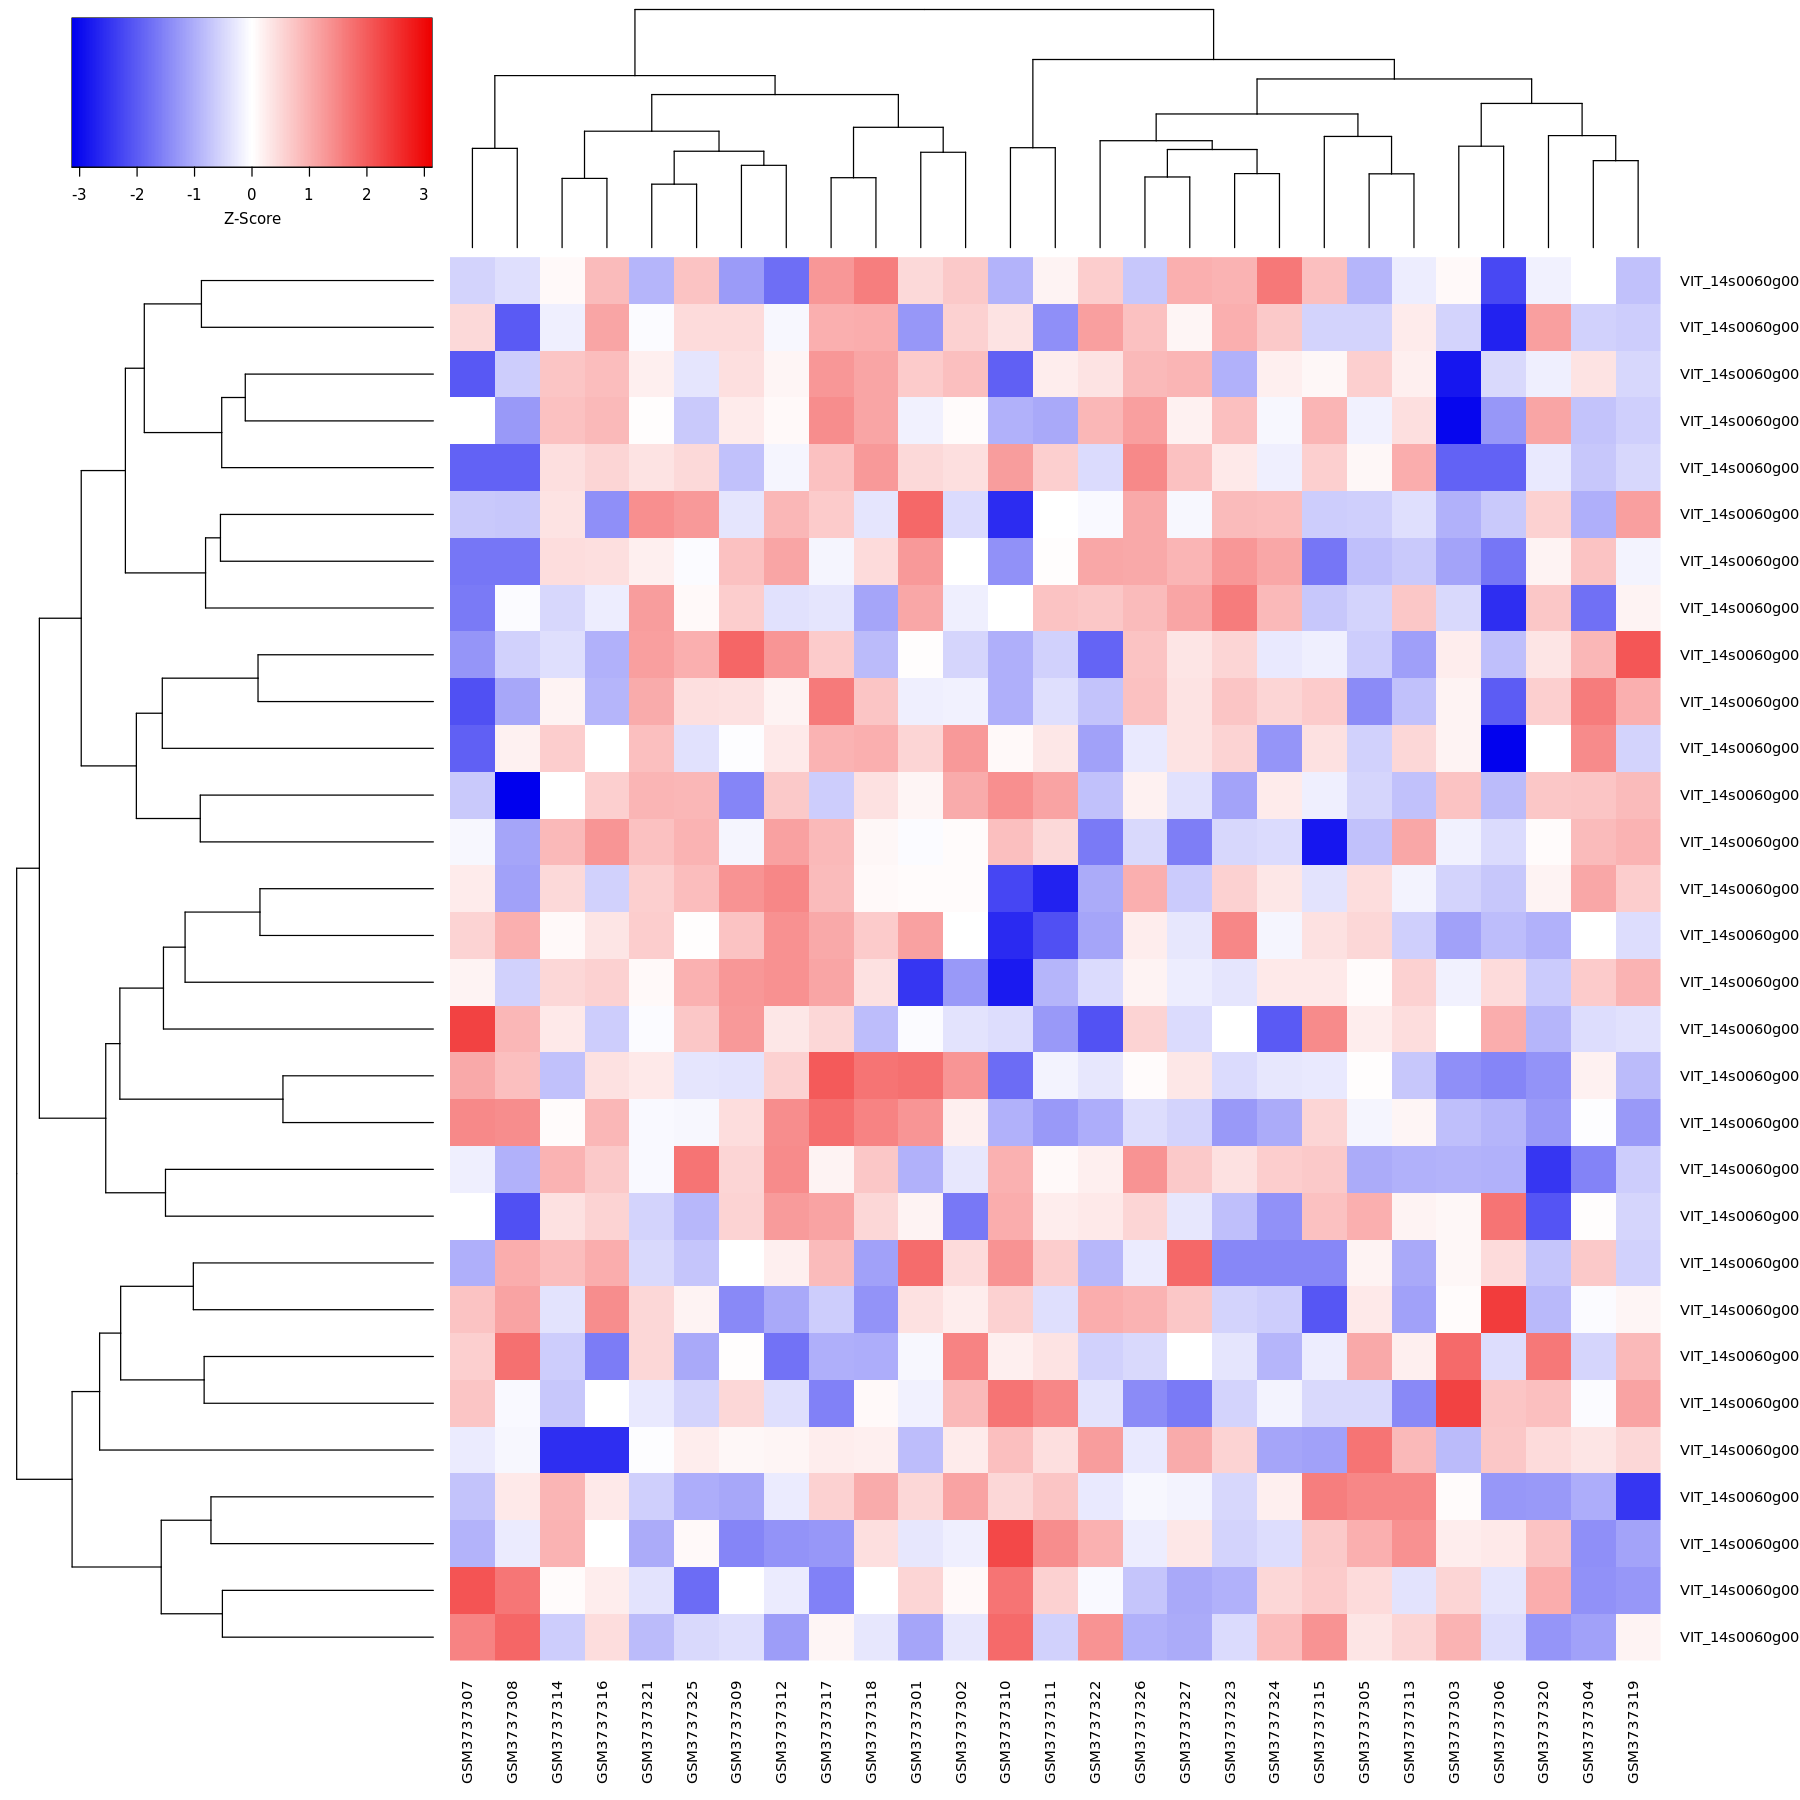

In [29]:
tT <- Xiangfei.EL35vsItalia.EL35
o <- order(tT$P.Value)
logCPM_o <- logCPM[o[1:30],]
coolmap(logCPM_o, margins=c(7,7), lhei=c(1,6), lwid=c(1,3))

# Functional Analysis (Pathway analysis)

## Gene ontology analysis using GOseq 

GOseq allows to perform a Gene Ontology (GO) analysis tailored to RNA-seq data as it accounts for the gene length bias in detection of over-representation  <a href="#ref12">[12]</a>

From the [GOseq vignette](https://www.bioconductor.org/packages/release/bioc/vignettes/goseq/inst/doc/goseq.pdf):

- GOseq first needs to quantify the length bias present in the dataset under consideration.
- This is done by calculating a Probability Weighting Function or PWF which can be thought of as a function which gives the probability that a gene will be differentially expressed (DE), based on its length alone.
- The PWF is calculated by fitting a monotonic spline to the binary data series of differential expression (1=DE, 0=Not DE) as a function of gene length.
- The PWF is used to weight the chance of selecting each gene when forming a null distribution for GO category membership.
- The fact that the PWF is calculated directly from the dataset under consideration makes this approach robust, only correcting for the length bias present in the data.
>“GO analysis of RNA-seq data requires the use of random sampling in order to generate a suitable null distribution for GO category membership and calculate each category’s significance for over representation amongst DE genes. … In most cases, the Wallenius distribution can be used to approximate the true null distribution, without any significant loss in accuracy. The goseq package implements this approximation as its default option.”

In order to perform the analysis two vectors are required: one containing all genes assayed in the RNA-seq experiment, the other containing all genes which are DE. If we assume that the vector of genes being assayed is namedassayed.genes and the vector of DE genes is named de.genes we can construct a named vector
suitable for use with goseq using the following:

In [30]:
library(goseq)
assayed.genes <- fc$annotation$GeneID
de.genes <-  Xiangfei.EL35vsXiangfei.EL36[(Xiangfei.EL35vsXiangfei.EL36$logFC > 1) & Xiangfei.EL35vsXiangfei.EL36$adj.P.Val< 0.01 ,]
gene.vector <- as.integer(assayed.genes%in%rownames(de.genes))
names(gene.vector) <- assayed.genes

### Activity
Replace the select contrast with one of your interest end change the double cut-off for the selection of DE genes for the enrichment analysis

## Non-native Gene Identifier or category test
If the organism, Gene Identifier or category test you wish to perform is not in the native goseq
database, you will have to supply one or all of the following:
- Length data: the length of each gene in your gene identifier format.
- Category mappings: the mapping (usually many-to-many) between the categories you wish to test for over/under representation amongst DE genes and genes in your gene identifier format.

In [32]:
GO_ann=read.table("/home/share/RNASeqPractical/references/GO_plant_slim_fixed.tab",header=F,sep="\t")[,1:2]
colnames(GO_ann) <- c("GeneIDs","GOTerms") 


Note: GO annotation is retrieved from [here](http://genomes.cribi.unipd.it/DATA/V1/ANNOTATION/).

## GO Analysis

### Fitting the Probability Weighting Function (PWF)
We first need to obtain a weighting for each gene, depending on its length, given by the PWF.
As you may have noticed when running supportedGenomes or supportedGeneIDs, length data is
available in the local database for our gene ID, “ensGene” and our genome, “hg19”. We will let
goseq automatically fetch this data from its databases.

Warning message in pcls(G):
“initial point very close to some inequality constraints”


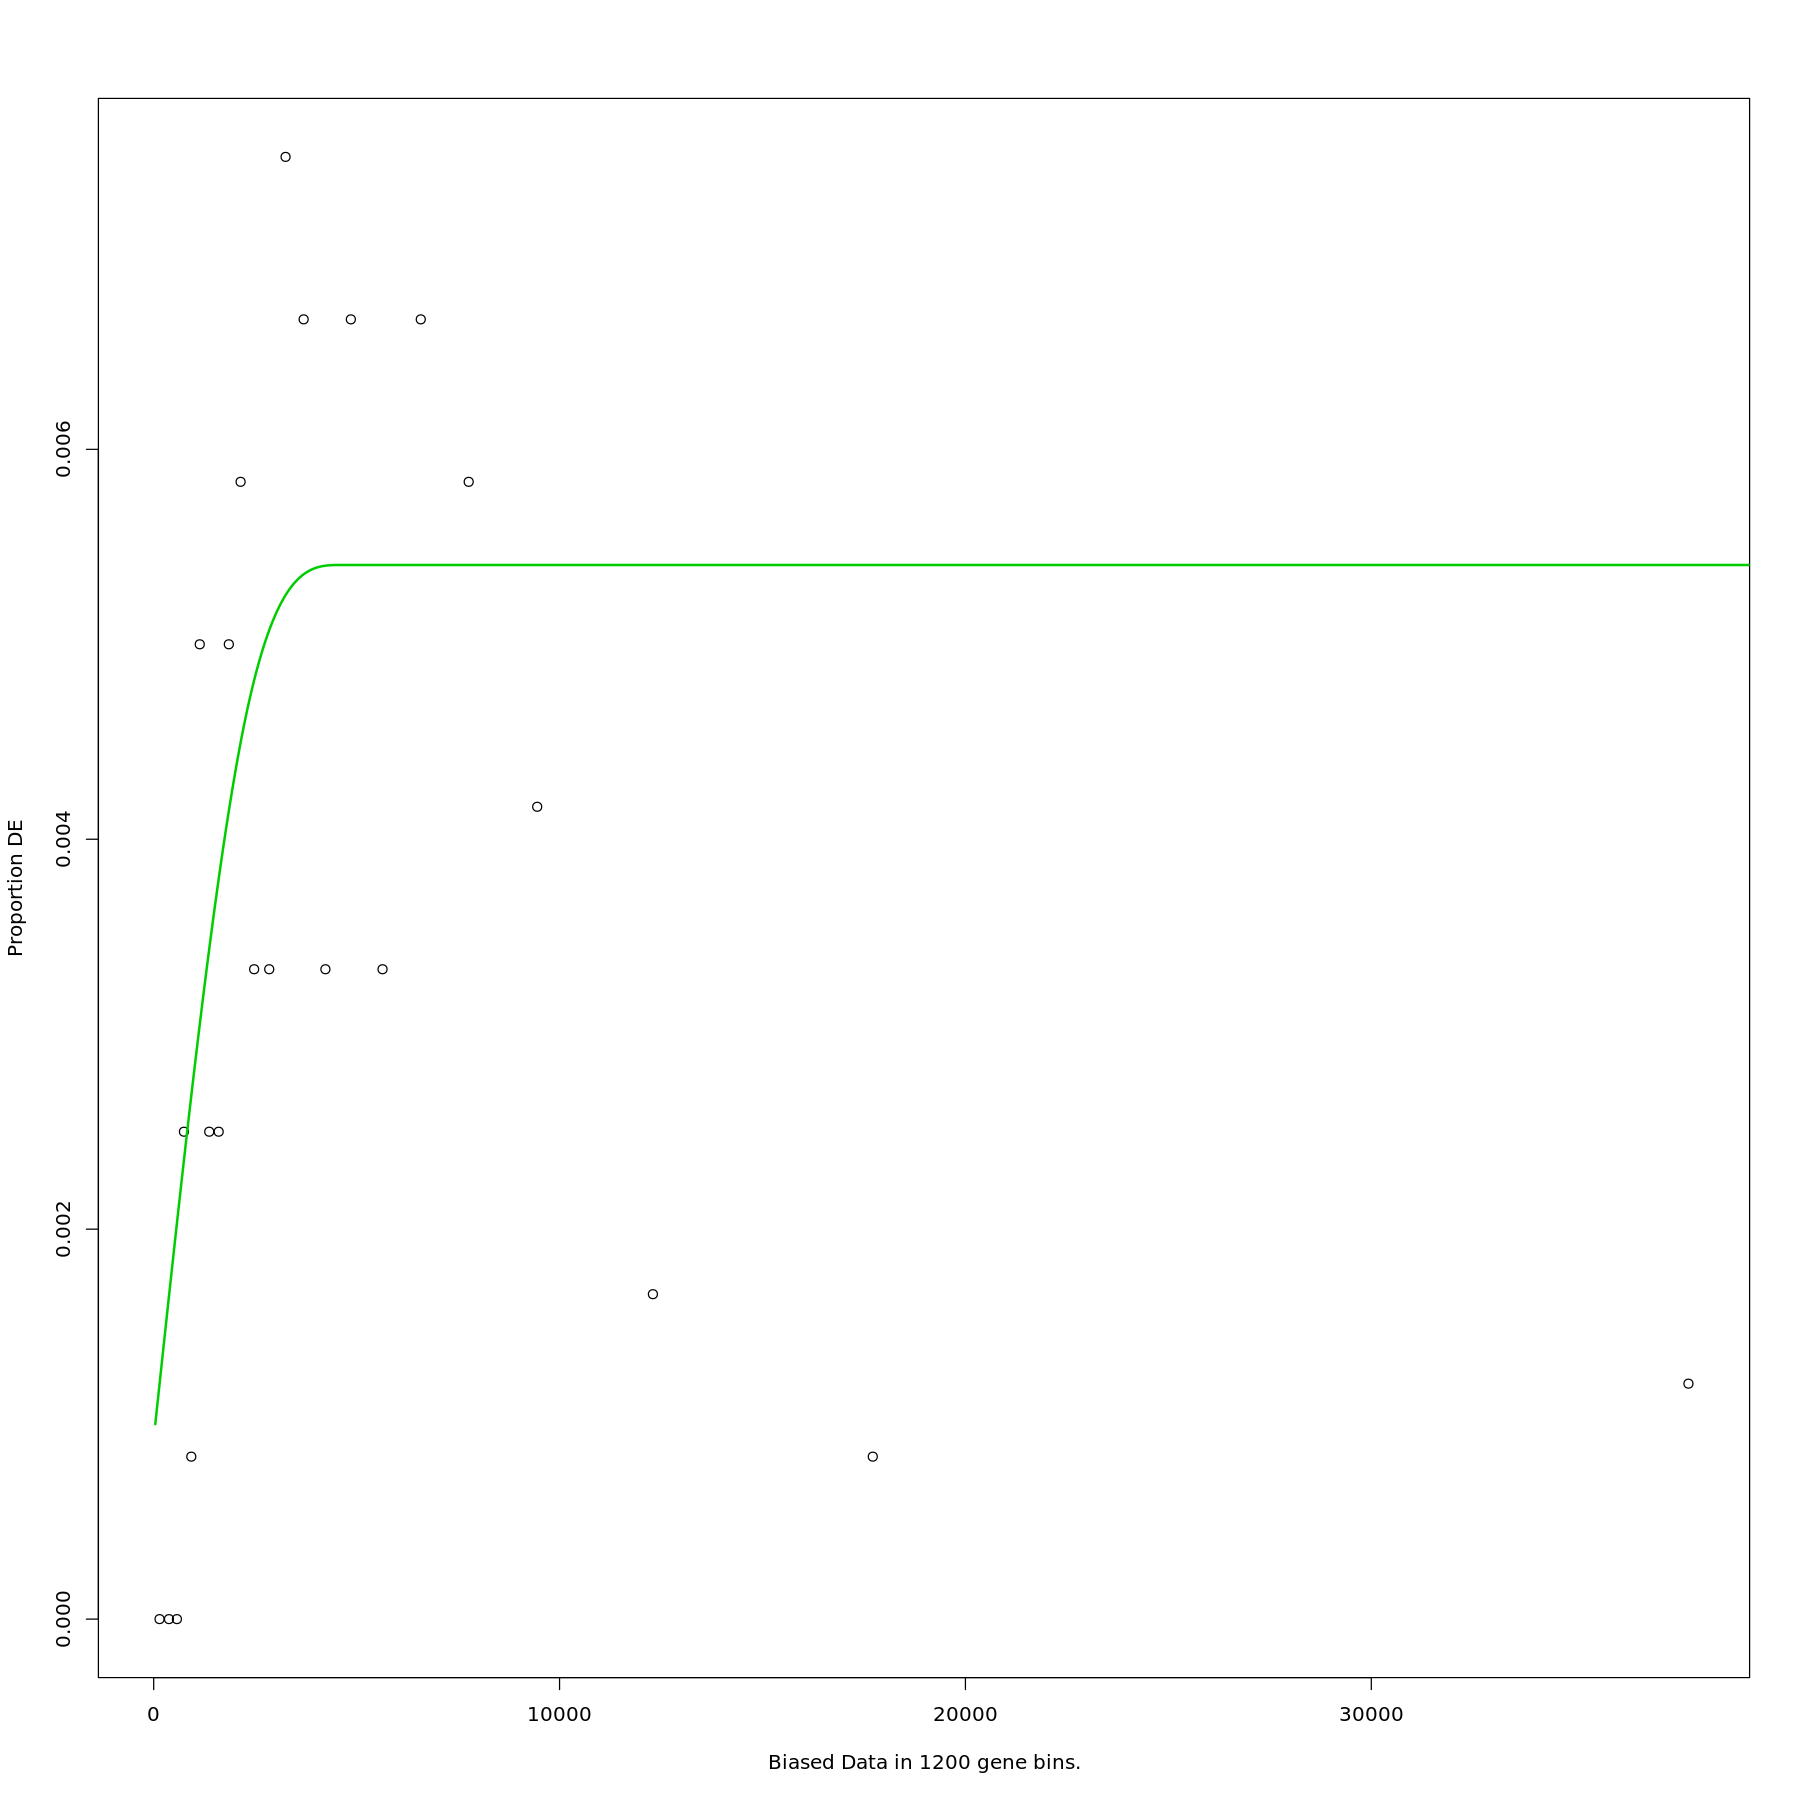

In [33]:
pwf=nullp(gene.vector,bias.data=fc$annotation$Length)

### Using the Wallenius approximation
We will use the default method, to calculate the over and under expressed GO
categories among DE genes.

In [35]:
GO.wall=goseq(pwf,gene2cat=GO_ann, use_genes_without_cat=TRUE)
head(GO.wall)

Using manually entered categories.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



category   over_represented_pvalue under_represented_pvalue numDEInCat
37 GO:0005794 0.0002524121            0.9999646                 7        
41 GO:0005886 0.0007689486            0.9997540                15        
48 GO:0006464 0.0013213397            0.9995370                16        
17 GO:0005488 0.0029038989            0.9985949                31        
23 GO:0005618 0.0032690093            0.9995020                 5        
25 GO:0005623 0.0059855164            0.9994915                 3        
   numInCat term                                  ontology
37  302     Golgi apparatus                       CC      
41 1504     plasma membrane                       CC      
48 1772     cellular protein modification process BP      
17 5149     binding                               MF      
23  295     cell wall                             CC      
25   91     cell                                  CC

### Making sense of the results
If you wish to identify categories significantly enriched/unenriched below some p-value cutoff, it is recommended to
first apply some kind of multiple hypothesis testing correction. For example, GO categories over
enriched using a .05 FDR cutoff are:

In [36]:
enriched.GO=GO.wall$category[p.adjust(GO.wall$over_represented_pvalue, method="BH")<.05]

Information about each term can be obtained from the [Gene Ontology website](http://www.geneontology.org) or tool like [http://revigo.irb.hr/](http://revigo.irb.hr/) or [http://bioinfo.cau.edu.cn/agriGO/](http://bioinfo.cau.edu.cn/agriGO/) or in R:

In [37]:
library(GO.db)
for(go in enriched.GO){
print(GOTERM[[go]])
cat("--------------------------------------\n")
}

GOID: GO:0005794
Term: Golgi apparatus
Ontology: CC
Definition: A compound membranous cytoplasmic organelle of eukaryotic
    cells, consisting of flattened, ribosome-free vesicles arranged in
    a more or less regular stack. The Golgi apparatus differs from the
    endoplasmic reticulum in often having slightly thicker membranes,
    appearing in sections as a characteristic shallow semicircle so
    that the convex side (cis or entry face) abuts the endoplasmic
    reticulum, secretory vesicles emerging from the concave side (trans
    or exit face). In vertebrate cells there is usually one such
    organelle, while in invertebrates and plants, where they are known
    usually as dictyosomes, there may be several scattered in the
    cytoplasm. The Golgi apparatus processes proteins produced on the
    ribosomes of the rough endoplasmic reticulum; such processing
    includes modification of the core oligosaccharides of
    glycoproteins, and the sorting and packaging of proteins fo

### Plot top 10 GOTERMS <a href="#ref13">[13]</a> 

```{r}
GO.wall %>% 
    top_n(10, wt=-over_represented_pvalue) %>% 
    mutate(hitsPerc=numDEInCat*100/numInCat) %>% 
    ggplot(aes(x=hitsPerc, 
               y= paste0(category," - ", term), 
               colour=over_represented_pvalue, 
               size=numDEInCat)) +
        geom_point() +
        expand_limits(x=0) +
        labs(x="Hits (%)", y="GO term", colour="p value", size="Count")
```

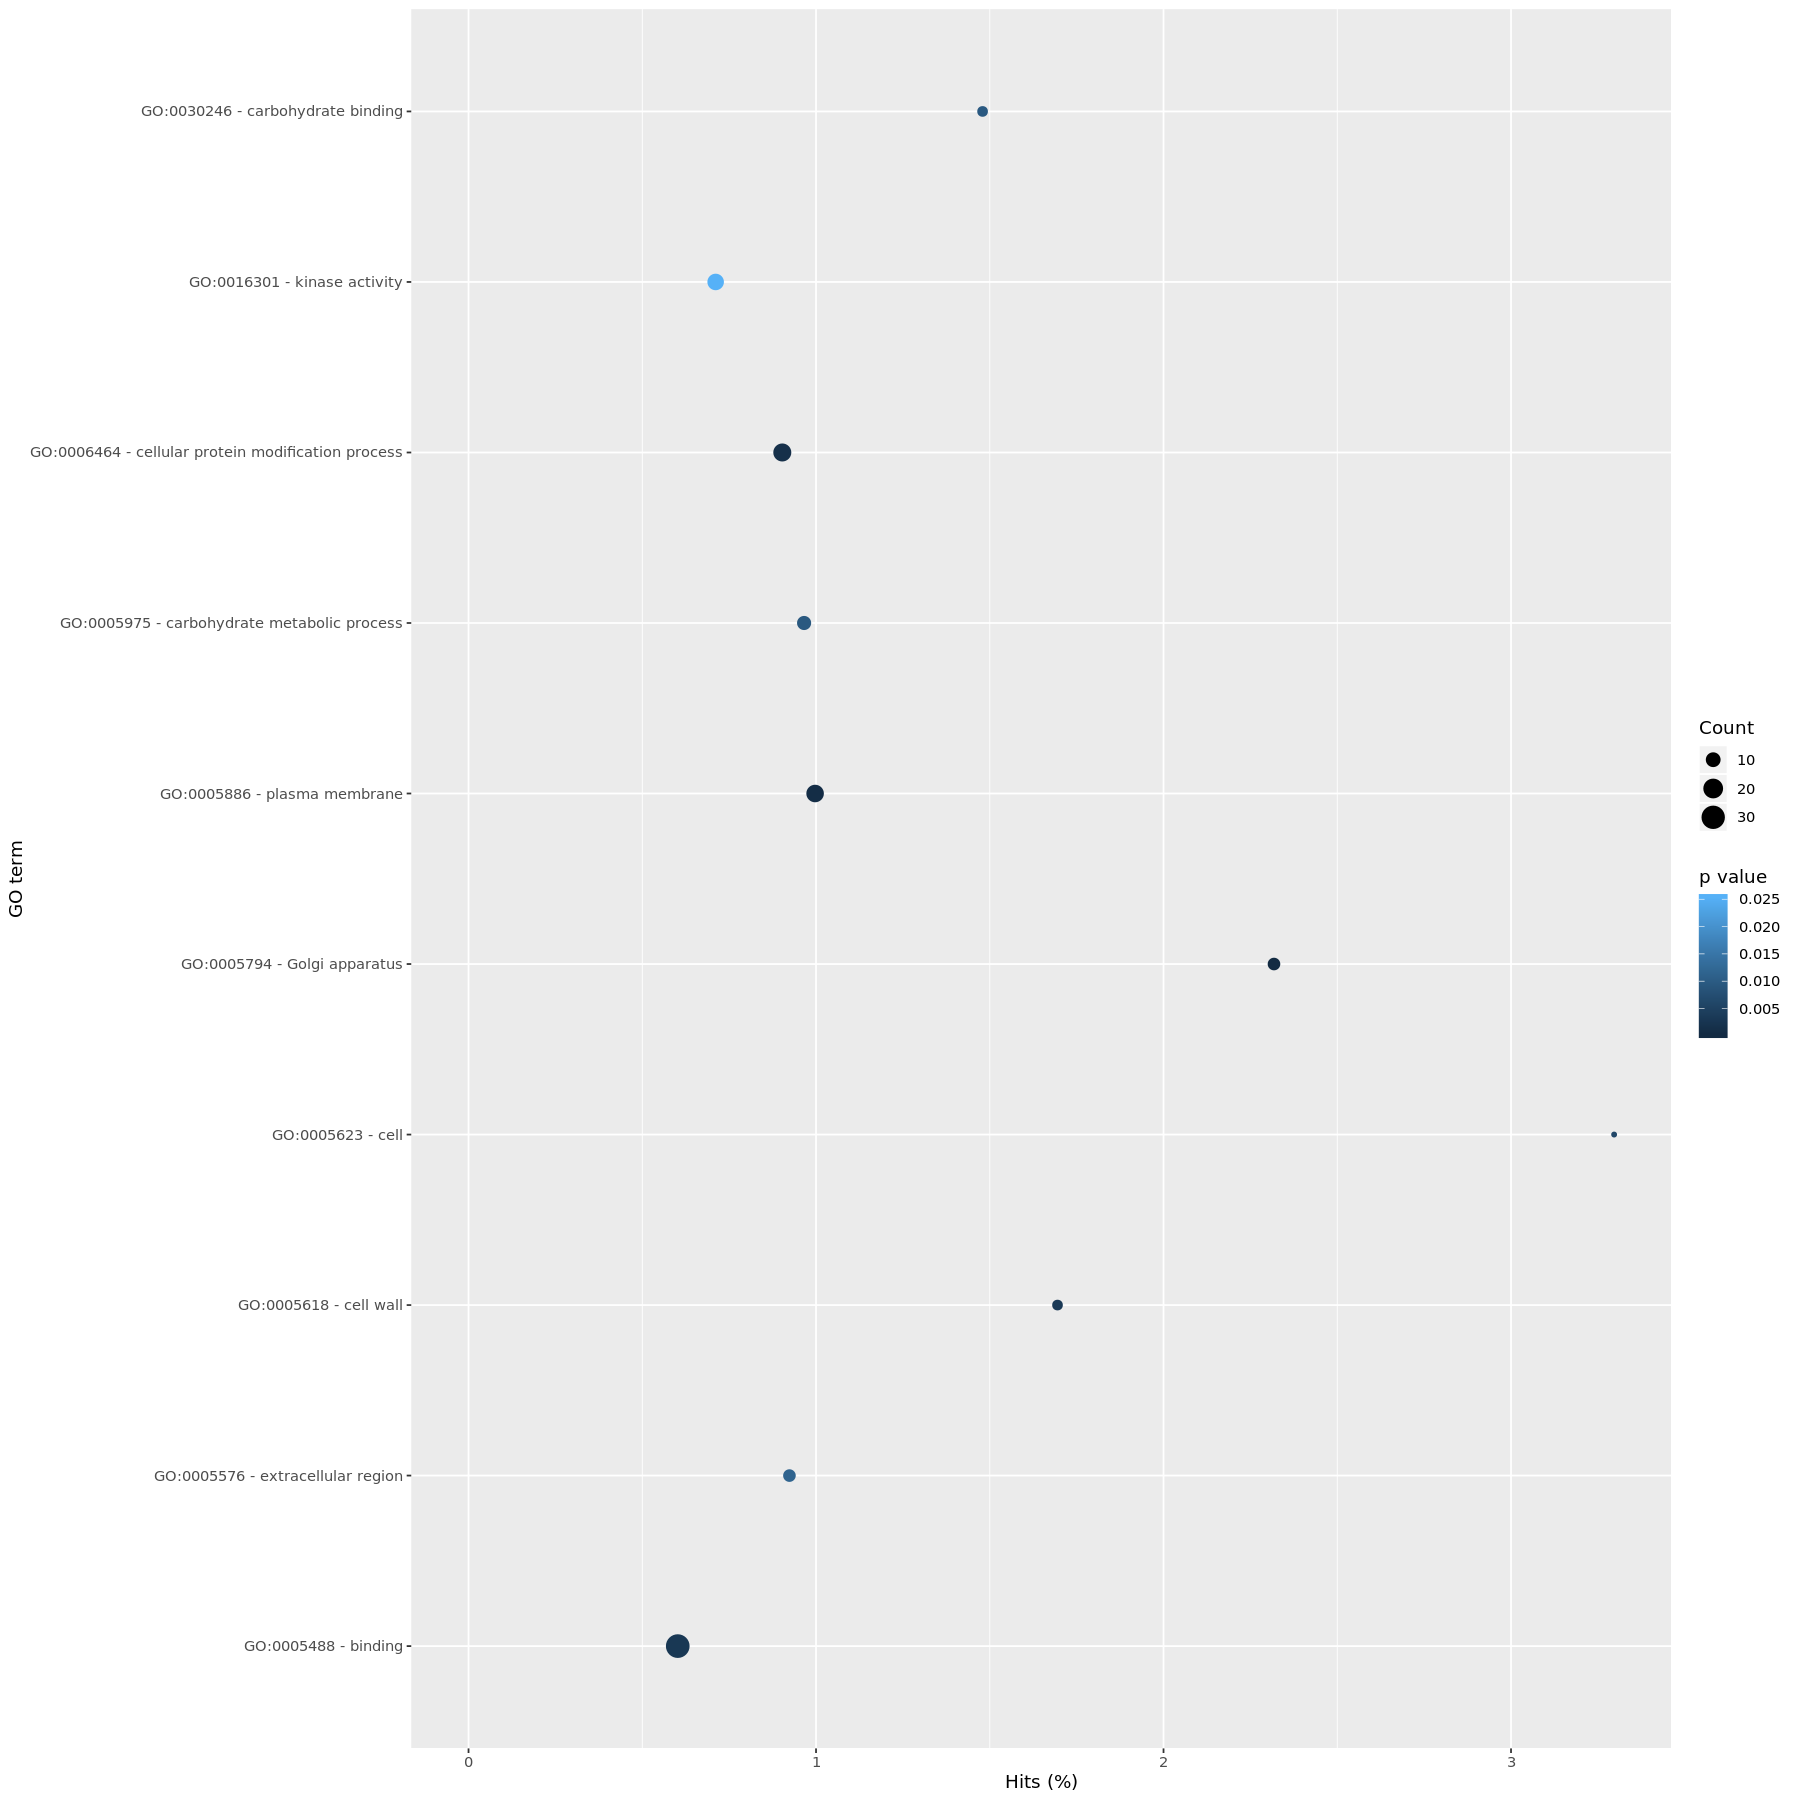

In [38]:
GO.wall %>% 
    top_n(10, wt=-over_represented_pvalue) %>% 
    mutate(hitsPerc=numDEInCat*100/numInCat) %>% 
    ggplot(aes(x=hitsPerc, 
               y= paste0(category," - ", term), 
               colour=over_represented_pvalue, 
               size=numDEInCat)) +
        geom_point() +
        expand_limits(x=0) +
        labs(x="Hits (%)", y="GO term", colour="p value", size="Count")

# Packages used
This practical depends on various packages from version 3.10 of the Bioconductor project, running on R version 3.6.2 or higher. The complete list of the packages used for this workflow are shown below:

In [31]:
(my_session <- sessionInfo())
#save.image(paste0("subread_analysis_",format(Sys.Date(), "%d-%m-%Y"),".RData"), compress = TRUE)

R version 3.6.2 (2019-12-12)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 10 (buster)

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.8.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.8.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] GO.db_3.10.0                AnnotationDbi_1.48.0       
 [3] goseq_1.38.0                geneLenDataBase_1.22.0     
 [5] BiasedUrn_1.07              edgeR_3.28.0               
 [7] limma_3.42.0                DESeq2_1.26.0              
 [9] SummarizedExperiment_1.16.1 DelayedArray_0.

# References

<a id='ref1'></a>1. Sun,L., Zhu,B., Zhang,X., Zhang,G., Yan,A., Wang,H., Wang,X. and Xu,H. (2019) Transcriptome profiles of three Muscat table grape cultivars to dissect the mechanism of terpene biosynthesis. Sci Data, 6.

<a id='ref2'></a>2. [Mapping between SRA IDs and accessing metadata with the Bioconductor SRAdb package](http://bergmanlab.genetics.uga.edu/?p=1072)

<a id='ref2bis'></a>2bis. Choudhary, S. (2019) pysradb: A Python package to query next-generation sequencing metadata and data from NCBI Sequence Read Archive. F1000Res, 8, 532.

<a id='ref3'></a>3. Babraham Bioinformatics - FastQC A Quality Control tool for High Throughput Sequence Data. Babraham Bioinformatics - FastQC A Quality Control tool for High Throughput Sequence Data 
https://www.bioinformatics.babraham.ac.uk/projects/fastqc/ (accessed Nov 21, 2019).

<a id='ref4'></a>4. Bolger, A. M., Lohse, M. and Usadel, B. (2014) Trimmomatic: a flexible trimmer for Illumina sequence data. Bioinformatics, 30, 2114–2120.

<a id='ref5'></a>5. Y. Liao, G. K. Smyth and W. Shi. “The Subread aligner: fast, accurate and scalable read mapping by seed-and-vote”. In: Nucleic Acids Research 41 (2013), p. 108.

<a id='ref6'></a>6. Liao, Y., Smyth, G. K. and Shi, W. (2014) featureCounts: an efficient general purpose program for assigning sequence reads to genomic features. Bioinformatics, 30, 923–930.

<a id='ref7'></a>7. [Principal Component Analysis Explained Visually](http://setosa.io/ev/principal-component-analysis/)

<a id='ref8'></a>8. Robinson, M. D., and A. Oshlack. 2010. “A Scaling Normalization Method for Differential Expression Analysis of RNA-seq Data.” Genome Biology 11 (3):R25.

<a id='ref9'></a>9. Chen, Y., Lun, A. T. L. and Smyth, G. K. (2016) From reads to genes to pathways: differential expression analysis of RNA-Seq experiments using Rsubread and the edgeR quasi-likelihood pipeline. F1000Research, 5, 1438.

<a id='ref10'></a>10. Law, C. W., Chen, Y., Shi, W., et al. (2014) voom: precision weights unlock linear model analysis tools for RNA-seq read counts. Genome Biology, 15, R29.

<a id='ref11'></a>11. Ritchie, M. E., Phipson, B., Wu, D., et al. (2015) limma powers differential expression analyses for RNA-sequencing and microarray studies. Nucl. Acids Res., gkv007.

<a id='ref12'></a>12. Young, M. D., Wakefield, M. J., Smyth, G. K., et al. (2010) Gene ontology analysis for RNA-seq: accounting for selection bias. Genome Biology, 11, R14.

<a id='ref13'></a>13. [GO enrichment analysis](https://bioinformatics-core-shared-training.github.io/cruk-summer-school-2018/RNASeq2018/html/06_Gene_set_testing.nb.html#go-enrichment-analysis)